# Plotting fire frequencies and burned areas at different spatiotemporal scales

Authors: Jatan Buch (v1, 220207) || (v2, 220216) || (v3, 220414) || (v4, 220420)

## 1. Packages

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
#from time import clock
from datetime import date, datetime, timedelta
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm
from copy import deepcopy

#Import and write files
import csv
import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray

from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader

#self-libraries
from fire_utils import *
from ml_utils import *

#Helper functions
from math import factorial
from scipy import stats
from scipy.special import gamma
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError
from tensorflow.python import ops
from tensorflow.python import debug as tf_debug

#Plot modules
import matplotlib.pyplot as plt
from plot_params import params
import matplotlib.pylab as pylab
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

#Stats modules
from scipy import stats
from scipy.stats import norm, pareto, genpareto
import statsmodels.api as sm
from scipy import stats, interpolate
from scipy.optimize import minimize

# Data processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, SplineTransformer
from sklearn.model_selection import train_test_split
import joblib
from sklearn.pipeline import make_pipeline

#modules for Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression

#modules for Neural Network
import tensorflow as tf
import tensorflow_probability as tfp
tfd= tfp.distributions
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
#from tensorflow.keras import layers
#from tensorflow.python.ops.parallel_for.gradients import jacobian

In [2]:
fire_file= "../data/burnarea_12km.nc"

## 2. Grid scale frequency

This module includes all plotting functions for the grid scale fire frequencies predicted using mixture density networks (MDN) and MLPs (DNN). Briefly, the workflow is as follows, 

2.1) load the output from various model runs (see `ml_grid_model.ipynb`) including: downsampled (ds), downsamped with alternate training range (alt_ds), and leave-one-region-out (loro) run; </br>
2.2) plot the cumulative annual and monthly fire frequencies for the entire western US study region; </br>
2.3) plot the monthly and annual fire frequencies for individual [L3 ecoregions](https://www.epa.gov/eco-research/level-iii-and-iv-ecoregions-continental-united-states).</br>

All the custom functions called below maybe found in the `ml_utils.py` library file. 

### 2.1 Loading model output

In [120]:
mdn_freq_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/mdn_mon_fire_freq_02_27_22_it_2_8192_0.3.h5') #['02_27_22', 2, 8192, '0.3']
mdn_freq_groups= mdn_freq_df.groupby('reg_indx')
mdn_ds_freq_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/mdn_ds_mon_fire_freq_03_01_22.h5') #03_01_22, 04_21_22;  04_17_22 --> with threshold
mdn_ds_freq_groups= mdn_ds_freq_df.groupby('reg_indx')
mdn_alt_ds_freq_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/mdn_ds_mon_fire_freq_03_02_22.h5') # leaves training data ut starting from month 264 instead of 372
mdn_alt_ds_freq_groups= mdn_ds_freq_df.groupby('reg_indx')
dnn_freq_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/dnn_mon_fire_freq_03_01_22_it_12_8192_0.3.h5')
dnn_freq_groups= dnn_freq_df.groupby('reg_indx')
dnn_ds_freq_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/dnn_ds_mon_fire_freq_02_25_22.h5')
dnn_ds_freq_groups= dnn_ds_freq_df.groupby('reg_indx')
mdn_loro_freq_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/mdn_ds_mon_fire_freq_03_03_22.h5') # loro; currently only has region 7

In [121]:
fire_file= "../data/burnarea_12km.nc"
mdn_mon_freq_df, mdn_ann_freq_df= calib_freq_predict(ml_freq_df= mdn_ds_freq_df, n_regs= 18, tot_months= 432, test_start= 420, test_tot= 12, ml_model= 'mdn') #debug= True, regindx= 7, arg_arr= ['linear', 'mean', 'mean'])
mdn_mon_freq_groups= mdn_mon_freq_df.groupby('reg_indx')
mdn_ann_freq_groups= mdn_ann_freq_df.groupby('reg_indx')

### 2.2 WUS frequencies

In [4]:
final_month= 432
tot_months= final_month #- start_month
n_regions= 18

#month_arr= np.linspace(start_month, final_month - 1, tot_months, dtype= np.int64)
month_arr= np.linspace(0, final_month - 1, tot_months, dtype= np.int64)
year_arr=  np.arange(1984, 2021, 4) #np.asarray([2006, 2009, 2012, 2015, 2018, 2021]) #np.asarray([2015, 2016, 2017, 2018, 2019, 2020])
yr_arr= np.arange(0, tot_months + 1, 12)

In [122]:
tot_mon_obs_freq_arr, tot_mon_pred_freq_arr, tot_mon_pred_high_2sig_arr, tot_mon_pred_low_2sig_arr, \
        tot_ann_obs_freq_arr, tot_ann_pred_freq_arr, tot_ann_pred_high_2sig_arr, tot_ann_pred_low_2sig_arr= cumm_fire_freq_func(mdn_mon_freq_df, mdn_ann_freq_df, \
                                                                                                                optflag= False)

tot_mon_freq_r= stats.pearsonr(np.sum(tot_mon_obs_freq_arr, axis= 0), np.sum(tot_mon_pred_freq_arr, axis= 0))[0]
tot_ann_freq_r= stats.pearsonr(np.sum(tot_ann_obs_freq_arr, axis= 0), np.sum(tot_ann_pred_freq_arr, axis= 0))[0]

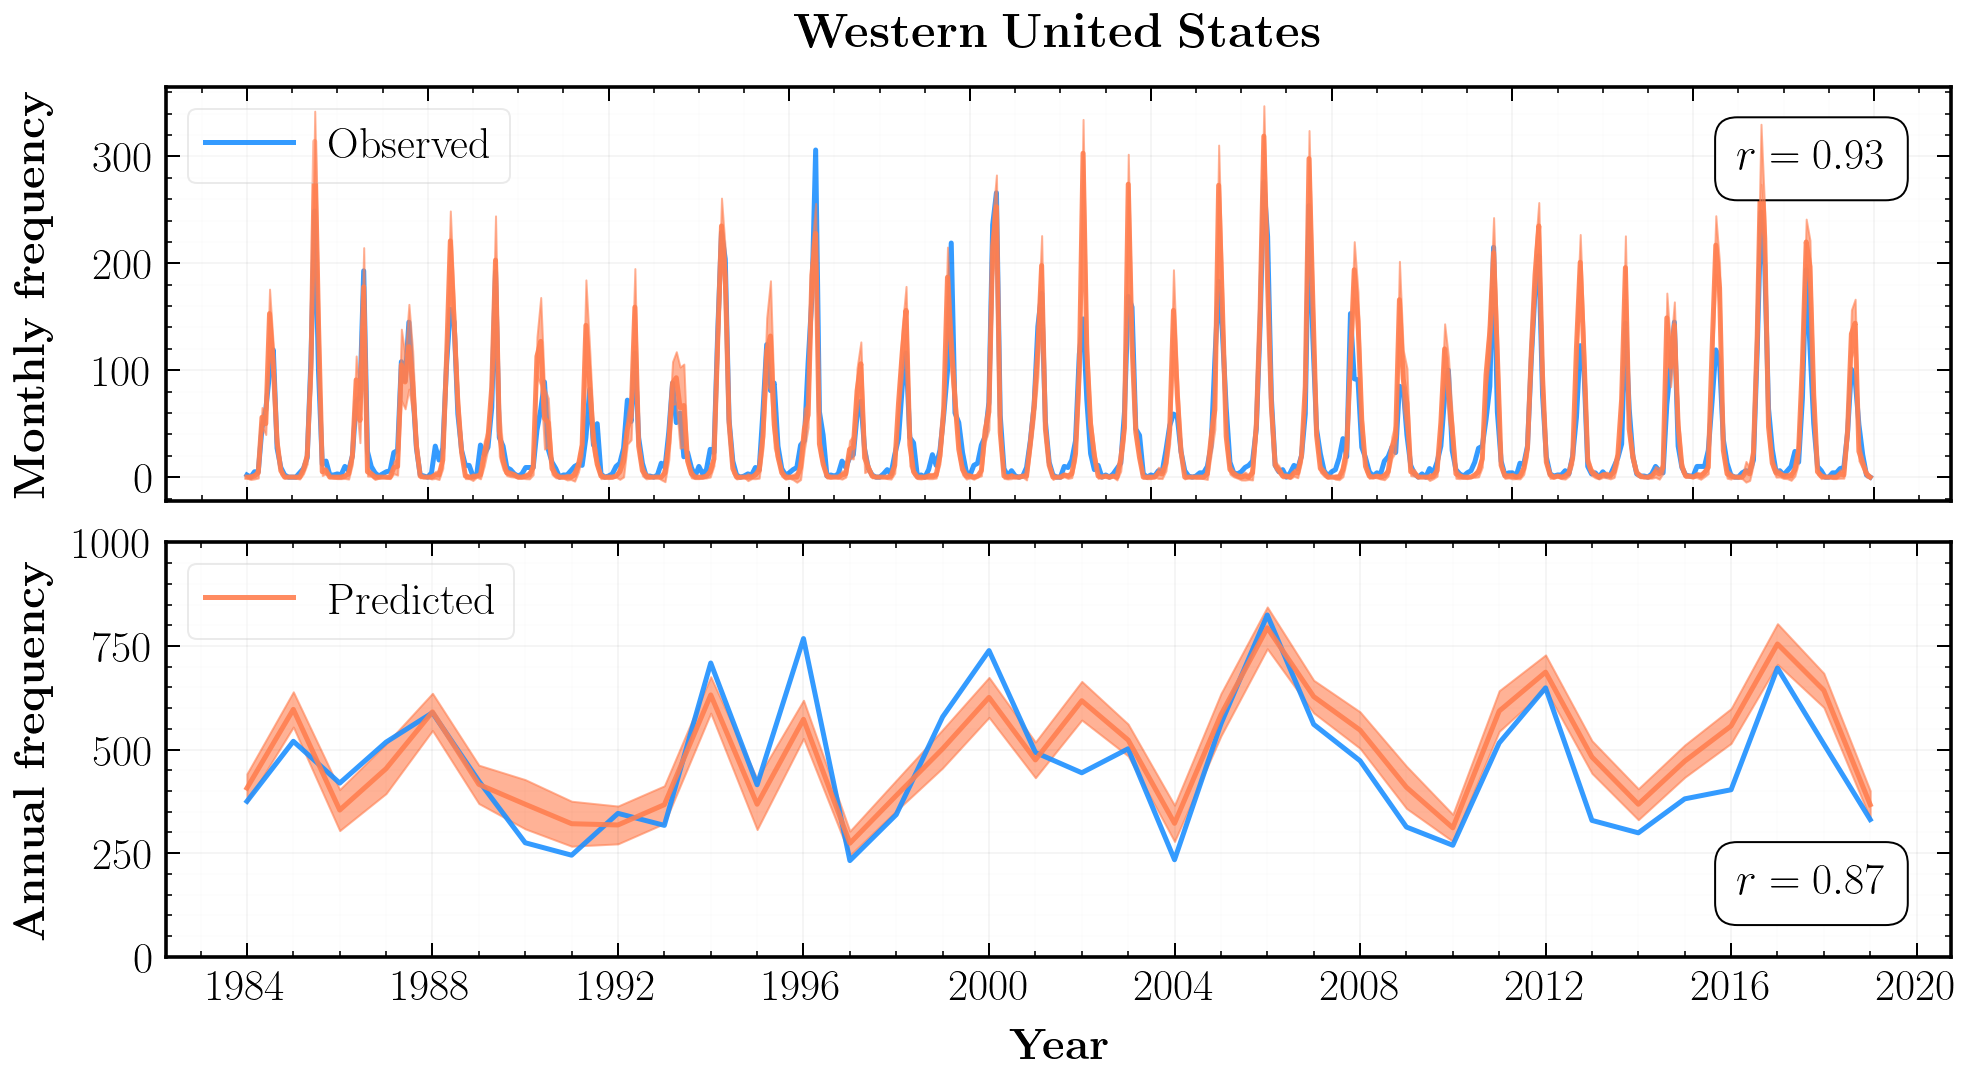

In [123]:
fig, ax= plt.subplots(2, 1, figsize=(16, 8))

ax[1].plot(yr_arr[:-1], np.sum(tot_ann_obs_freq_arr, axis= 0), color= 'dodgerblue');
ax[1].plot(yr_arr[:-1], np.sum(tot_ann_pred_freq_arr, axis= 0), color= 'coral', label= 'Predicted');
ax[1].fill_between(yr_arr[:-1], tot_ann_pred_high_2sig_arr, tot_ann_pred_low_2sig_arr, color= 'coral', alpha= 0.6)
ax[1].set_ylabel(r'{\bf Annual frequency}', fontsize= 22);
ax[1].set_xlabel(r'{\bf Year}', fontsize= 22);
ax[1].set_ylim(0, 1000);
ax[1].set_xticks((year_arr - 1984)*12);
ax[1].set_xticklabels(year_arr)
ax[1].text(0.88, 0.15, r'$r = %.2f$'%tot_ann_freq_r, fontsize= 22, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[1].transAxes)
ax[1].legend(loc='upper left', frameon= True, fontsize= 22);
ax[1].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax[1].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[1].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');

fig.subplots_adjust(hspace= 0.1)

ax[0].plot(month_arr, np.sum(tot_mon_obs_freq_arr, axis= 0), color= 'dodgerblue', label= 'Observed', zorder= 1);
ax[0].plot(month_arr, np.sum(tot_mon_pred_freq_arr, axis= 0), color= 'coral');
ax[0].fill_between(month_arr, tot_mon_pred_high_2sig_arr, tot_mon_pred_low_2sig_arr, color= 'coral', alpha= 0.6, zorder= 10)
ax[0].set_title(r'${\bf Western \ United \ States}$', fontsize= 24, pad= 20);
ax[0].set_ylabel(r'{\bf Monthly frequency}', fontsize= 22, labelpad= 20);
ax[0].set_xticks((year_arr - 1984)*12);
ax[0].set_xticklabels([])
ax[0].text(0.88, 0.8, r'$r = %.2f$'%tot_mon_freq_r, fontsize= 22, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[0].transAxes)
ax[0].legend(loc='upper left', frameon= True, fontsize= 22);
ax[0].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax[0].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[0].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../paper_plots/ml_fire_freq_wus.pdf', bbox_inches='tight', dpi= 300);

### 2.3 Regional frequencies

In [41]:
startmon= 0
startyr= int((startmon)/12 + 1984)
totmonths= final_month - startmon
month_arr= np.linspace(startmon, final_month - 1, totmonths, dtype= np.int64)
year_arr= np.arange(1984, 2021, 4) #np.asarray([2006, 2009, 2012, 2015, 2018, 2021]) #np.asarray([2015, 2016, 2017, 2018, 2019, 2020])
yr_arr= np.arange(0, tot_months + 1, 12) 

reg_name= {1: "Sierra Nevada", 2: "North Coast", 3: "Central Coast", 4: "South Coast", 5: "Pacific NW", 6: "Columbia Plateau", 7:"Northern Rockies", \
          8: "Middle Rockies", 9: "Southern Rockies", 10: "AM Semidesert", 11: "AZ/NM Mts.", 12: "IM Semidesert", 13: "IM Desert", 14: "Northern Great Plains", \
          15: "High Plains", 16: "CO Plateau", 17: "SW Tablelands", 18: "CH Desert"}
ind_grid_1= [[1, 6], [7, 8]]
ind_grid_2= [[11, 12], [13, 14]]

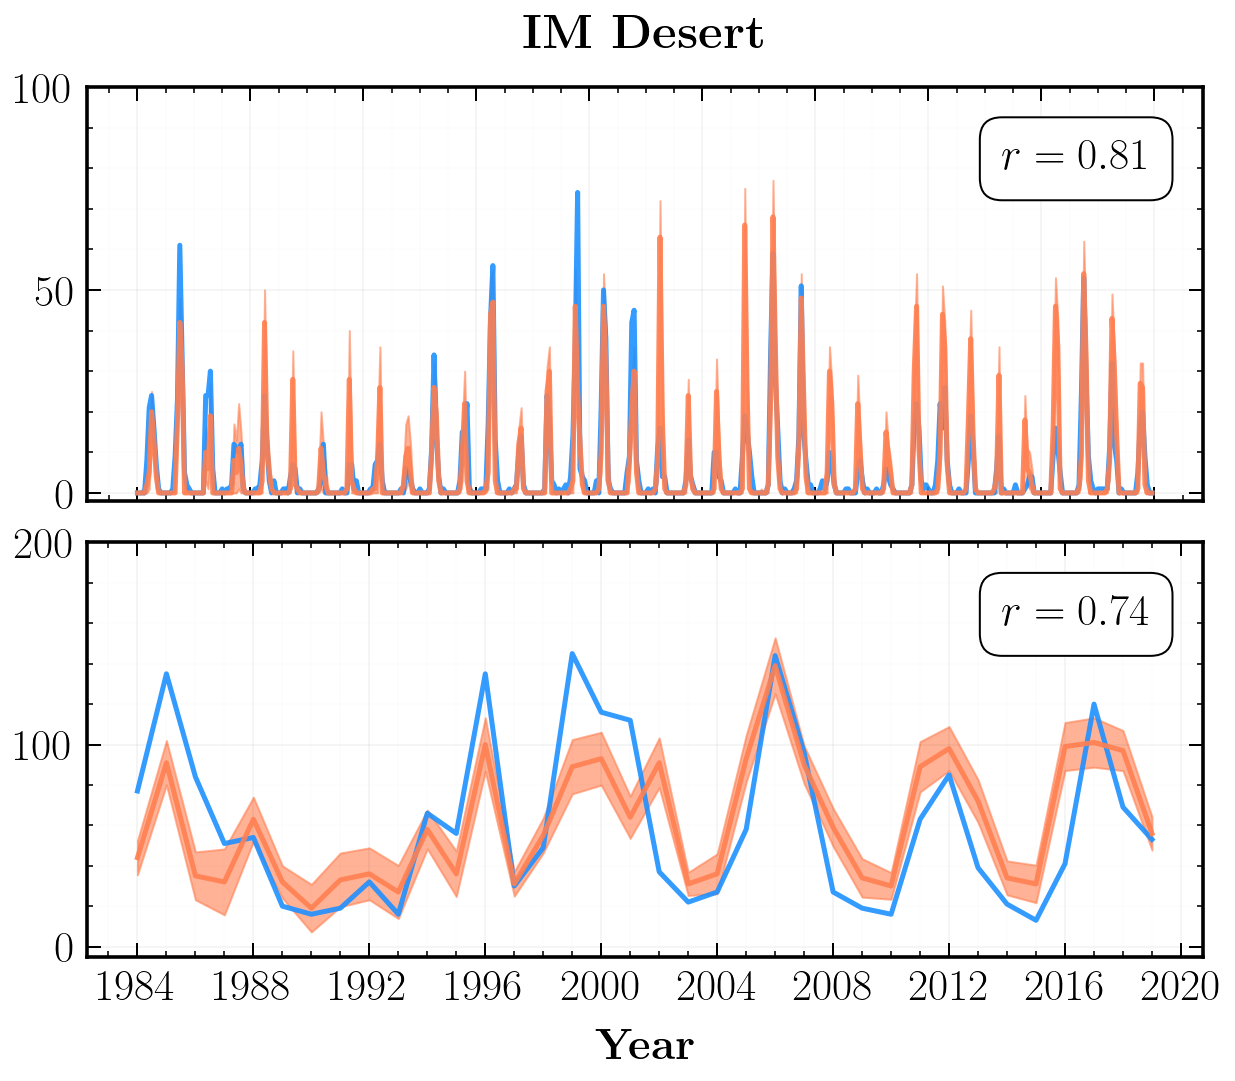

In [150]:
fig, ax= plt.subplots(2, 1, figsize=(10, 8))

regindx= 13
reg_mon_r_calib= stats.pearsonr(mdn_mon_freq_groups.get_group(regindx)['obs_freq'], mdn_mon_freq_groups.get_group(regindx)['pred_mean_freq'])[0]
reg_ann_r_calib= stats.pearsonr(mdn_ann_freq_groups.get_group(regindx)['obs_freq'], mdn_ann_freq_groups.get_group(regindx)['pred_mean_freq'])[0]
pos_arr= [[0.8, 0.1], [0.82, 0.8]]
pred_ann_low_2sig= mdn_ann_freq_groups.get_group(regindx)['pred_low_2sig']
pred_ann_low_2sig[pred_ann_low_2sig < 0]= 0

ax[0].plot(month_arr, mdn_mon_freq_groups.get_group(regindx)['obs_freq'][startmon:], color= 'dodgerblue', lw= 2.5, label= 'Observed'); #, label= 'Observed'
ax[0].plot(month_arr, mdn_mon_freq_groups.get_group(regindx)['pred_mean_freq'], color= 'coral', lw= 2.5); # label= 'Predicted'
ax[0].fill_between(month_arr, mdn_mon_freq_groups.get_group(regindx)['pred_high_2sig'], mdn_mon_freq_groups.get_group(regindx)['pred_low_2sig'], color= 'coral', alpha= 0.6)
#ax[0].set_ylabel(r'{\bf Monthly frequency}', fontsize= 22, labelpad= 10);
ax[0].set_ylim(-2, 100);
ax[0].set_xticks((year_arr - startyr)*12 + startmon);
ax[0].set_xticklabels([])
ax[0].text(pos_arr[1][0], pos_arr[1][1], r'$r = %.2f$'%reg_mon_r_calib, fontsize= 22, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[0].transAxes)
ax[0].set_title(r'{\bf %s}'%reg_name[regindx], fontsize= 24, pad= 20);
#ax[0].legend(loc='upper left', frameon= True, fontsize= 20);
ax[0].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax[0].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[0].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');

fig.subplots_adjust(hspace= 0.1)

ax[1].plot(yr_arr[:-1], mdn_ann_freq_groups.get_group(regindx)['obs_freq'], color= 'dodgerblue', lw= 2.5);
ax[1].plot(yr_arr[:-1], mdn_ann_freq_groups.get_group(regindx)['pred_mean_freq'], color= 'coral', lw= 2.5, label= 'Predicted');
ax[1].fill_between(yr_arr[:-1], mdn_ann_freq_groups.get_group(regindx)['pred_high_2sig'], pred_ann_low_2sig, color= 'coral', alpha= 0.6);
#ax[1].set_ylabel(r'{\bf Annual frequency}', fontsize= 22);
ax[1].set_ylim(-5, 200);
ax[1].set_xlabel(r'{\bf Year}', fontsize= 22);
ax[1].set_xticks((year_arr - startyr)*12 + startmon);
ax[1].set_xticklabels(year_arr)
ax[1].text(pos_arr[1][0], pos_arr[1][1], r'$r = %.2f$'%reg_ann_r_calib, fontsize= 22, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[1].transAxes)
#ax[1].legend(loc='upper left', frameon= True, fontsize= 20);
ax[1].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax[1].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[1].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#fig.savefig('../paper_plots/ml_fire_freq_imdesert.pdf', bbox_inches='tight', dpi= 300); #bbox_inches='tight',

#### Monthly

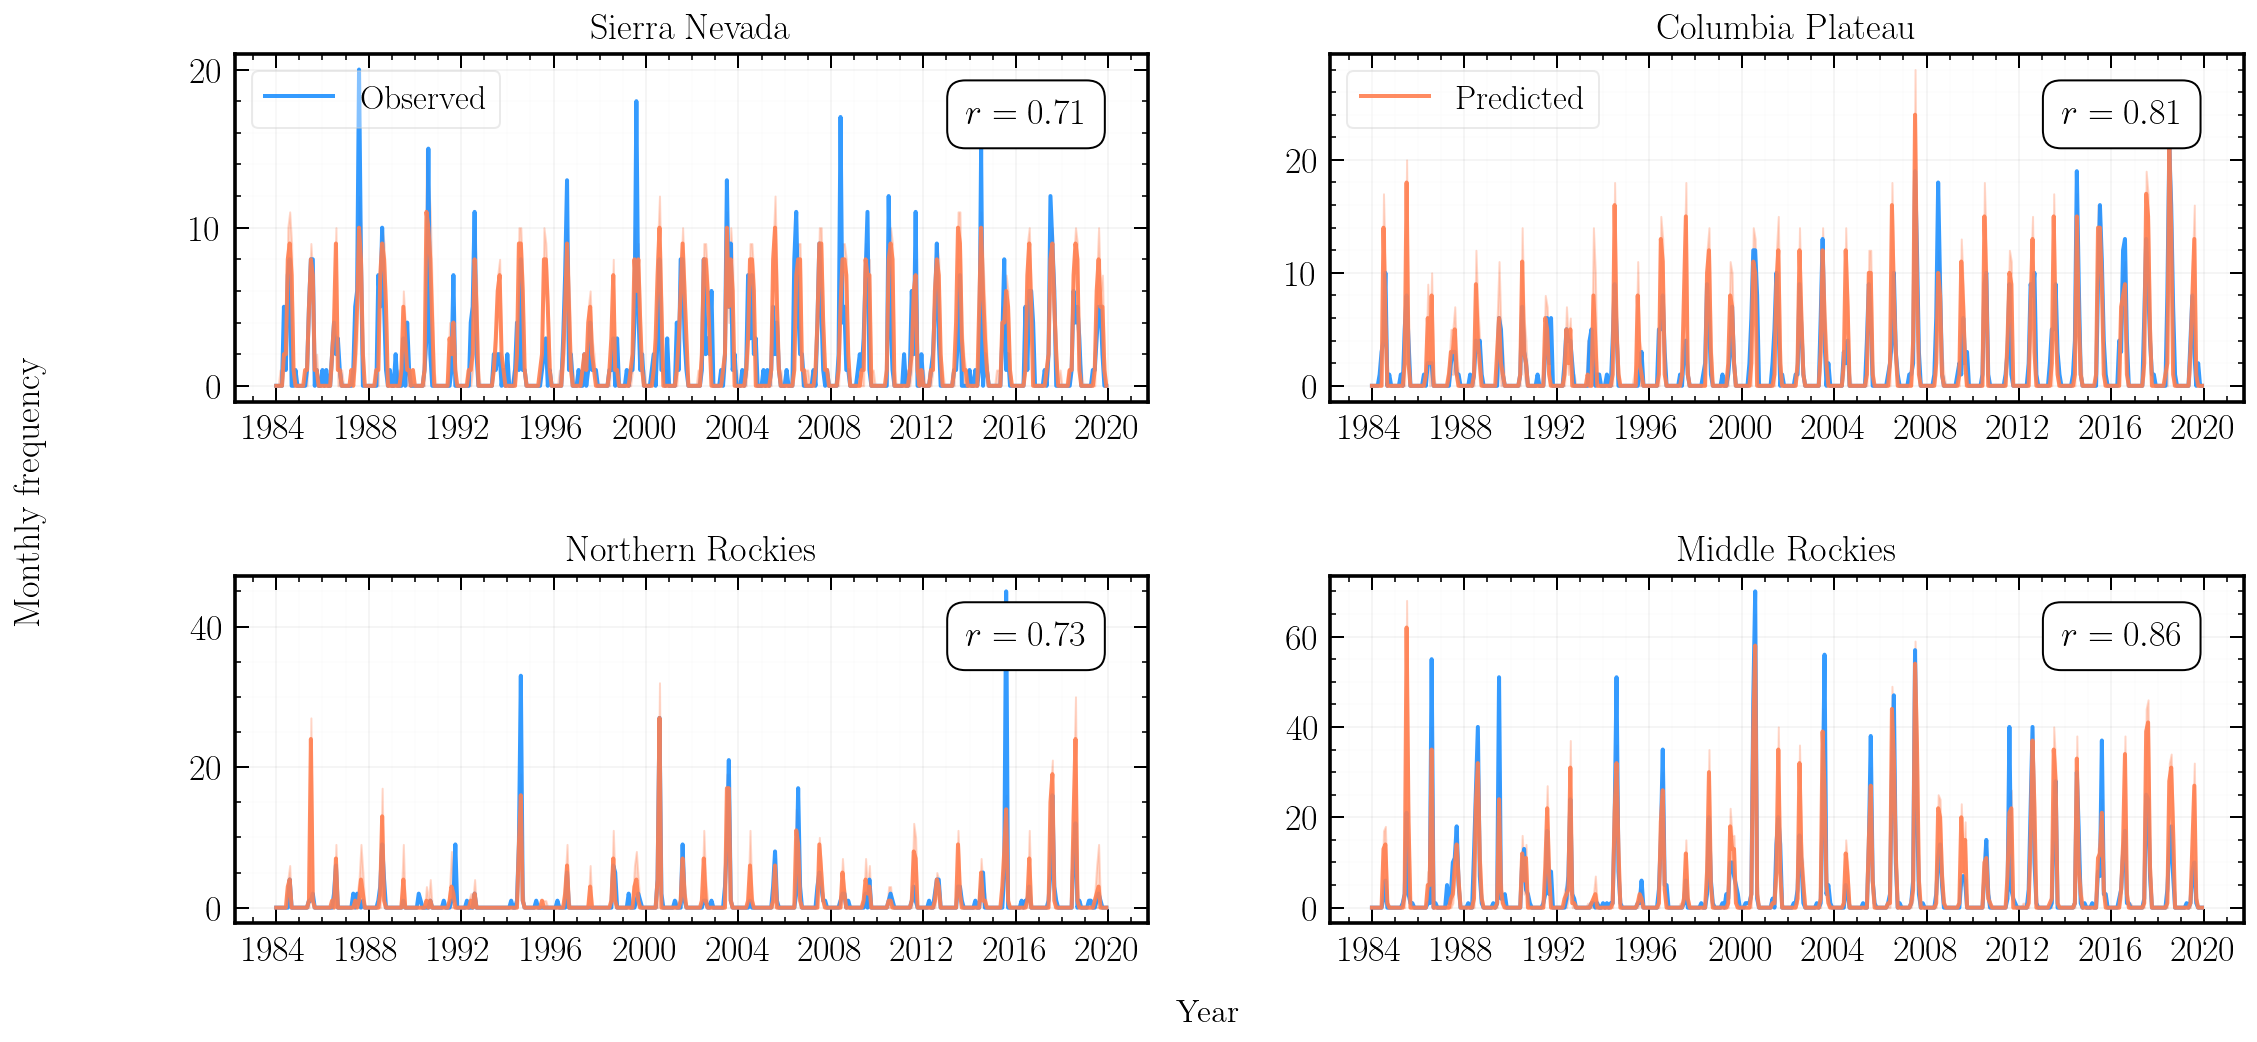

In [85]:
fig, ax= plt.subplots(2, 2, figsize=(18, 8))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly frequency', va='center', rotation='vertical', fontsize= 18);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

for i in range(2):
    for j in range(2):
        regindx= ind_grid_1[i][j]
        reg_mon_r_calib= stats.pearsonr(mdn_mon_freq_groups.get_group(regindx)['obs_freq'], mdn_mon_freq_groups.get_group(regindx)['pred_mean_freq'])[0]
        
        if i+j == 0:
            ax[i, j].plot(month_arr, mdn_mon_freq_groups.get_group(regindx)['obs_freq'][startmon:], color= 'dodgerblue', lw= 2, label= 'Observed');
            ax[i, j].legend(loc='upper left', frameon= True);
        else:
            ax[i, j].plot(month_arr, mdn_mon_freq_groups.get_group(regindx)['obs_freq'][startmon:], color= 'dodgerblue', lw= 2);
        if (i==0)&(j==1):
            ax[i, j].plot(month_arr, mdn_mon_freq_groups.get_group(regindx)['pred_mean_freq'][startmon:], color= 'coral', lw= 2, label= 'Predicted');
            ax[i, j].legend(loc='upper left', frameon= True);
        else:
            ax[i, j].plot(month_arr, mdn_mon_freq_groups.get_group(regindx)['pred_mean_freq'][startmon:], color= 'coral', lw= 2);
        ax[i, j].fill_between(month_arr, mdn_mon_freq_groups.get_group(regindx)['pred_high_2sig'][startmon:], \
                              mdn_mon_freq_groups.get_group(regindx)['pred_low_2sig'][startmon:], color= 'coral', alpha= 0.3)
        ax[i, j].set_title(reg_name[regindx], fontsize= 18);
        ax[i, j].set_xticks((year_arr - startyr)*12 + startmon);
        ax[i, j].set_xticklabels(year_arr)
        ax[i, j].text(0.8, 0.8, r'$r = %.2f$'%reg_mon_r_calib, fontsize= 18, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[i, j].transAxes)
            
        fig.subplots_adjust(hspace= 0.5)
        #fig.minorticks_on()
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_grid_mon_fire_freq_2.pdf', bbox_inches='tight');

#### Annual

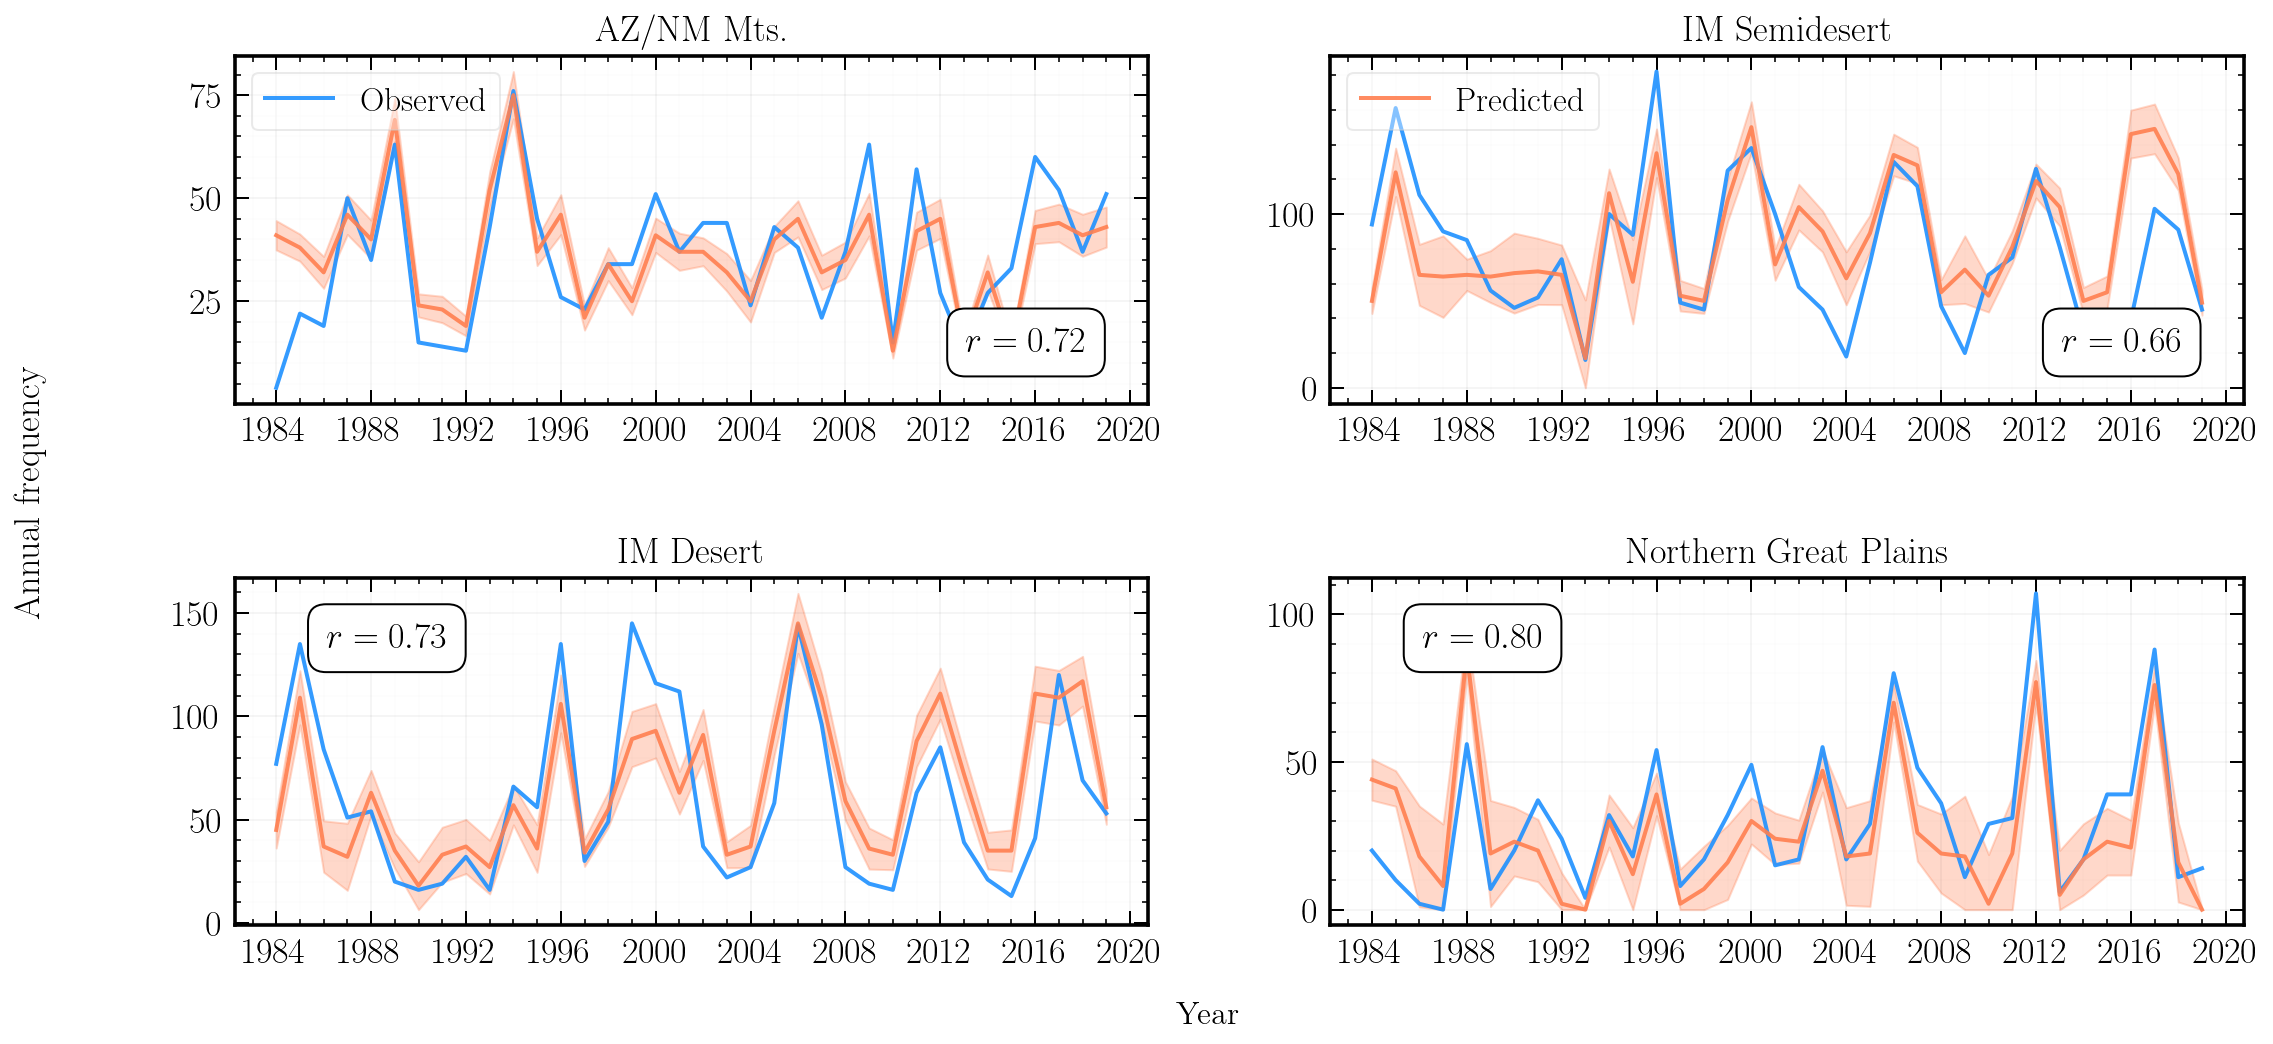

In [86]:
fig, ax= plt.subplots(2, 2, figsize=(18, 8))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Annual frequency', va='center', rotation='vertical', fontsize= 18);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

for i in range(2):
    for j in range(2):
        regindx= ind_grid_2[i][j]
        reg_ann_r_calib= stats.pearsonr(mdn_ann_freq_groups.get_group(regindx)['obs_freq'], mdn_ann_freq_groups.get_group(regindx)['pred_mean_freq'])[0]
        pos_arr= [[0.8, 0.15], [0.1, 0.8]]
        pred_ann_low_2sig= mdn_ann_freq_groups.get_group(regindx)['pred_low_2sig']
        pred_ann_low_2sig[pred_ann_low_2sig < 0]= 0
        
        if i+j == 0:
            ax[i, j].plot(yr_arr[:-1], mdn_ann_freq_groups.get_group(regindx)['obs_freq'], color= 'dodgerblue', lw= 2, label= 'Observed');
            ax[i, j].legend(loc='upper left', frameon= True);
        else:
            ax[i, j].plot(yr_arr[:-1], mdn_ann_freq_groups.get_group(regindx)['obs_freq'], color= 'dodgerblue', lw= 2);
        if (i==0)&(j==1):
            ax[i, j].plot(yr_arr[:-1], mdn_ann_freq_groups.get_group(regindx)['pred_mean_freq'], color= 'coral', lw= 2, label= 'Predicted');
            ax[i, j].legend(loc='upper left', frameon= True);
        else:
            ax[i, j].plot(yr_arr[:-1], mdn_ann_freq_groups.get_group(regindx)['pred_mean_freq'], color= 'coral', lw= 2);
        ax[i, j].fill_between(yr_arr[:-1], mdn_ann_freq_groups.get_group(regindx)['pred_high_2sig'], pred_ann_low_2sig, color= 'coral', alpha= 0.3)
        ax[i, j].set_title(reg_name[regindx], fontsize= 18);
        ax[i, j].set_xticks((year_arr - startyr)*12 + startmon);
        ax[i, j].set_xticklabels(year_arr)
        ax[i, j].text(pos_arr[i][0], pos_arr[i][1], r'$r = %.2f$'%reg_ann_r_calib, fontsize= 18, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[i, j].transAxes)
            
        fig.subplots_adjust(hspace= 0.5)
        #fig.minorticks_on()
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_grid_mon_fire_freq_2.pdf', bbox_inches='tight');

## 3. Grid fire locations

Plots for predicted and observed fire locations at an L3 ecoregion level that may be chosen using the `l3region` keyword. Options include the following ecoregions: </br>
{"ca_sierra", "ca_north_coast", "ca_cent_coast", "ca_south_coast", "pnw_mts", "columbia_plateau", "northern_rockies", "middle_rockies", "southern_rockies", "am_semidesert", "aznm_mts", "im_semidesert", "im_desert", "northern_great_plains", "high_plains", "colorado_plateau", "sw_tablelands", "ch_desert"}

All the custom functions called below maybe found in the `ml_utils.py` library file. 

### 3.1 Cumulative monthly locations

In [4]:
l3region= "northern_rockies"
run_id, it, bs, p_frac= ['02_27_22', 2, 8192, '0.3']
reg_pred_freq= bailey_ecoprovince_mask('../sav_files/pred_freq_%s'%run_id + '_%s'%bs + '_pfrac_%s'%str(p_frac) + '_iter_run_%d.nc'%it, region= l3region)
reg_obs_freq= bailey_ecoprovince_mask('../sav_files/obs_freq.nc', region= l3region)
lat_long_fire_grid= coord_transform(reg_pred_freq['X'][:].data, reg_pred_freq['Y'][:].data, input_crs= 'EPSG:5070')

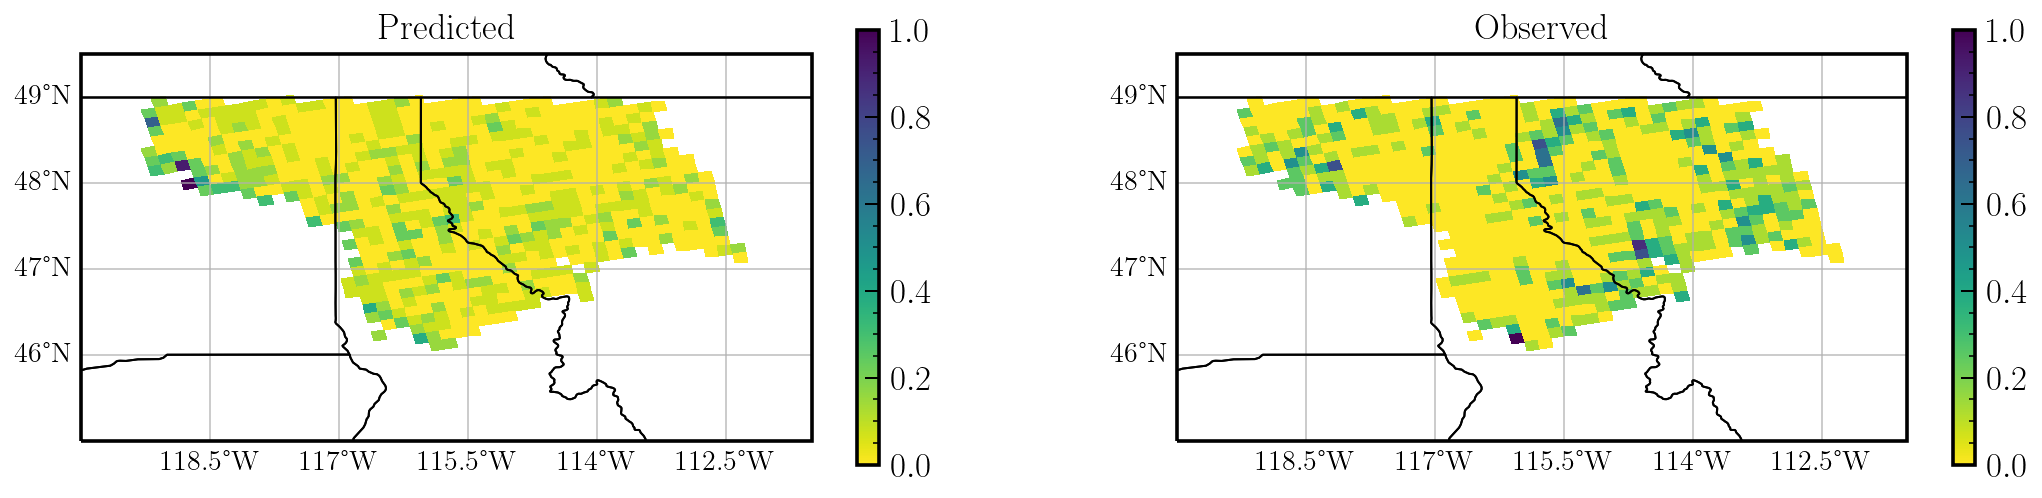

In [5]:
extent = [-120, -111.5, 45, 49.5] #[-120.5, -112.5, 42, 48.5] #[-124.5, -115.5, 32, 42.5] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

fig= plt.figure(figsize=(18, 4)) 

ax0= plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax0.set_extent(extent);

ax0.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax0.add_feature(cfeature.STATES, edgecolor='black', zorder= 10);

gl= ax0.gridlines(draw_labels=True, alpha= 0.8);
gl.top_labels = False;
gl.right_labels = False;
gl.xlabel_style = {'size': 14};
gl.ylabel_style = {'size': 14};

CS = ax0.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], np.sum(reg_pred_freq.values, axis= 0)/np.nanmax(np.sum(reg_pred_freq.values, axis= 0)), cmap=plt.cm.viridis_r)
cbar= fig.colorbar(CS, ax= ax0)
ax0.set_title(r'$\rm{Predicted}$', fontsize= 18);

ax1= plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax1.set_extent(extent);

ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax1.add_feature(cfeature.STATES, edgecolor='black', zorder= 10);

gl1= ax1.gridlines(draw_labels=True, alpha= 0.8);
gl1.top_labels = False;
gl1.right_labels = False;
gl1.xlabel_style = {'size': 14};
gl1.ylabel_style = {'size': 14};

CS1 = ax1.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], np.sum(reg_obs_freq.values, axis= 0)/np.nanmax(np.sum(reg_obs_freq.values, axis= 0)), cmap=plt.cm.viridis_r) #
cbar1= fig.colorbar(CS1)
ax1.set_title(r'$\rm{Observed}$', fontsize= 18);
#plt.savefig('../plots/grid_freq_loc_nrockies.jpg', bbox_inches='tight');

### 3.2 Longterm locations

In [6]:
l3region= "northern_rockies"
reg_obs_prob_freq= bailey_ecoprovince_mask('../sav_files/pred_freq_longterm_prob.nc', region= l3region)
reg_obs_freq= bailey_ecoprovince_mask('../sav_files/obs_freq.nc', region= l3region)
lat_long_fire_grid= coord_transform(reg_obs_freq['X'][:].data, reg_obs_freq['Y'][:].data, input_crs= 'EPSG:5070')

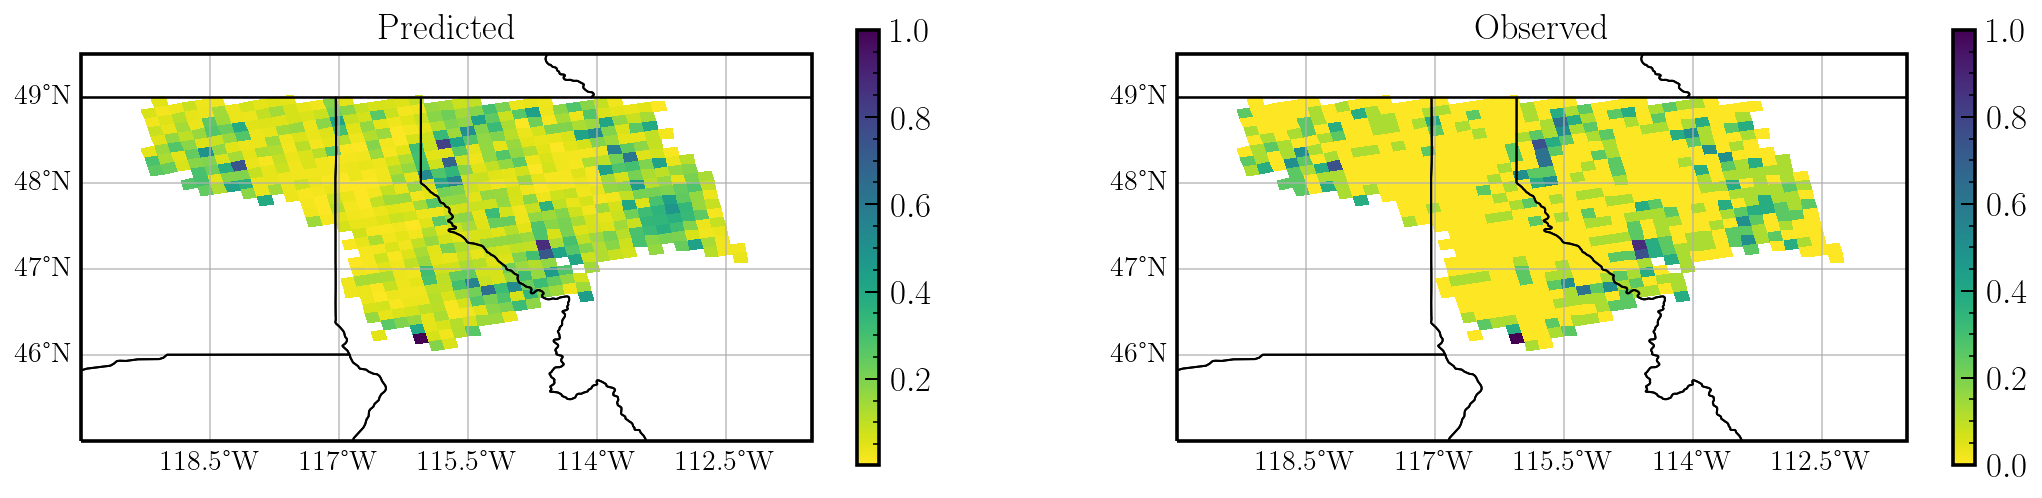

In [7]:
extent = [-120, -111.5, 45, 49.5]  #[-120, -111.5, 45, 49.5] #[-124.5, -115.5, 32, 42.5] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

fig= plt.figure(figsize=(18, 4)) 

ax0= plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax0.set_extent(extent);

ax0.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax0.add_feature(cfeature.STATES, edgecolor='black', zorder= 10);

gl= ax0.gridlines(draw_labels=True, alpha= 0.8);
gl.top_labels = False;
gl.right_labels = False;
gl.xlabel_style = {'size': 14};
gl.ylabel_style = {'size': 14};

CS = ax0.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], reg_obs_prob_freq/np.max(reg_obs_prob_freq).values, cmap=plt.cm.viridis_r)
cbar= fig.colorbar(CS, ax= ax0)
ax0.set_title(r'$\rm{Predicted}$', fontsize= 18);

ax1= plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax1.set_extent(extent);

ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax1.add_feature(cfeature.STATES, edgecolor='black', zorder= 10);

gl1= ax1.gridlines(draw_labels=True, alpha= 0.8);
gl1.top_labels = False;
gl1.right_labels = False;
gl1.xlabel_style = {'size': 14};
gl1.ylabel_style = {'size': 14};

CS1 = ax1.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], np.sum(reg_obs_freq.values, axis= 0)/np.nanmax(np.sum(reg_obs_freq.values, axis= 0)), cmap=plt.cm.viridis_r) #
cbar1= fig.colorbar(CS1)
ax1.set_title(r'$\rm{Observed}$', fontsize= 18);
#plt.savefig('../plots/grid_freq_loc_nrockies.jpg', bbox_inches='tight');

## 4. Fire size model

This module includes all plotting functions for the grid scale fire sizes predicted using mixture density networks (MDNs). Briefly, the workflow is as follows, 

4.1) load the output from model runs (see `ml_grid_fire_size.ipynb`) with various loss functions including mixtures of: Generalized Pareto distribution (gpd), extreme fire size weighted GPD (gpd_ext), Lognormal distribution (lognorm), and Lognormal-GPD distribution (lognorm_gpd); </br>
4.2) plot the cumulative annual and monthly burned areas for the entire western US study region; </br>
4.3) plot the monthly and annual burned areas for individual L3 ecoregions;</br>
4.4) compare the empirical cumulative distribution functions (CDFs) of observed and predicted monthly burned areas;</br>
4.5) compare the empirical CDF of observed fire _sizes_ with the theoretical CDFs corresponding to MDN models with different loss functions.</br>

All the custom functions called below maybe found in the `ml_utils.py` library file. 

### 4.1 Loading model outputs

In [20]:
size_id= '05_13_22'
freq_id= '04_17_22'
ml_flag= False

if ml_flag:
    reg_ml_gpd_size_df= pd.read_hdf('../sav_files/fire_size_pred_dfs/gpd_mon_fire_size_%s'%size_id + '_ml_freq_ml_loc_run_%s'%freq_id + '_df.h5')
    reg_ml_gpd_ext_size_df= pd.read_hdf('../sav_files/fire_size_pred_dfs/gpd_ext_mon_fire_size_%s'%size_id + '_ml_freq_ml_loc_run_%s'%freq_id + '_df.h5')
reg_gpd_data_size_df= pd.read_hdf('../sav_files/fire_size_pred_dfs/gpd_mon_fire_size_%s'%size_id + '_data_freq_%s_df.h5'%freq_id)
reg_gpd_ext_data_size_df= pd.read_hdf('../sav_files/fire_size_pred_dfs/gpd_ext_mon_fire_size_%s'%size_id + '_data_freq_%s_df.h5'%freq_id) #loc_ml_
#reg_lognorm_gpd_data_size_df= pd.read_hdf('../sav_files/grid_size_runs_%s'%size_id + '/lognorm_gpd_mon_fire_size_%s'%size_id + '_data_freq_df.h5')
#reg_gpd_gpd_data_size_df= pd.read_hdf('../sav_files/gpd_gpd_tot_mon_fire_size_%s'%size_id + '_data_freq_df.h5')

### 4.2 WUS sizes

In [16]:
final_month= 432
tot_months= final_month #- start_month
n_regions= 18

#month_arr= np.linspace(start_month, final_month - 1, tot_months, dtype= np.int64)
month_arr= np.linspace(0, final_month - 1, tot_months, dtype= np.int64)
year_arr=  np.arange(1984, 2021, 4) #np.asarray([2006, 2009, 2012, 2015, 2018, 2021]) #np.asarray([2015, 2016, 2017, 2018, 2019, 2020])
yr_arr= np.arange(0, tot_months + 1, 12)

break_year= 2004 #2002
break_month= (break_year + 1 - 1984)*12

In [21]:
# Setting timebreak = True implies that the resultant time series will be a combnination of the MDN-gpd model time series for T < 2004 and MDN-gpd_ext for T >= 2004.
# Use the optflag= True argument to drop regions with monthly correlations less than 0.6 from the cummulative burned area time series
# Use the regarr argument for specifying custom regions: # regarr= [1, 4, 6, 7, 8, 10, 15] (forested) #regarr= [5, 11, 12, 13, 9, 14, 16, 17] (nonforested)

tot_mon_obs_size_arr, tot_mon_pred_size_arr, tot_mon_pred_1sig_arr, tot_ann_obs_size_arr, \
            tot_ann_pred_size_arr, tot_ann_pred_1sig_arr= cumm_fire_size_func(firefile= fire_file, reg_size_df= reg_gpd_data_size_df, tot_months= tot_months, \
                                                        optflag= False, timebreak= True, breakmon= break_month, reg_gpd_ext_size_df= reg_gpd_ext_data_size_df) 

In [22]:
tot_ann_pred_high_1sig_arr= tot_ann_pred_size_arr + tot_ann_pred_1sig_arr
tot_ann_pred_low_1sig_arr= tot_ann_pred_size_arr - tot_ann_pred_1sig_arr
tot_mon_pred_high_1sig_arr= tot_mon_pred_size_arr + tot_mon_pred_1sig_arr
tot_mon_pred_low_1sig_arr= tot_mon_pred_size_arr - tot_mon_pred_1sig_arr
tot_mon_pred_low_1sig_arr[tot_mon_pred_low_1sig_arr < 0]= 0

tot_mon_size_r= stats.pearsonr(np.sum(tot_mon_obs_size_arr, axis= 0), tot_mon_pred_size_arr)[0] #stats.pearsonr(np.sum(mon_obs_arr, axis= 0), np.sum(mon_pred_arr, axis= 0))[0]
tot_ann_size_r= stats.pearsonr(np.sum(tot_ann_obs_size_arr, axis= 0), tot_ann_pred_size_arr)[0] #stats.pearsonr(np.sum(ann_obs_arr, axis= 0), np.sum(ann_pred_arr, axis= 0))[0]

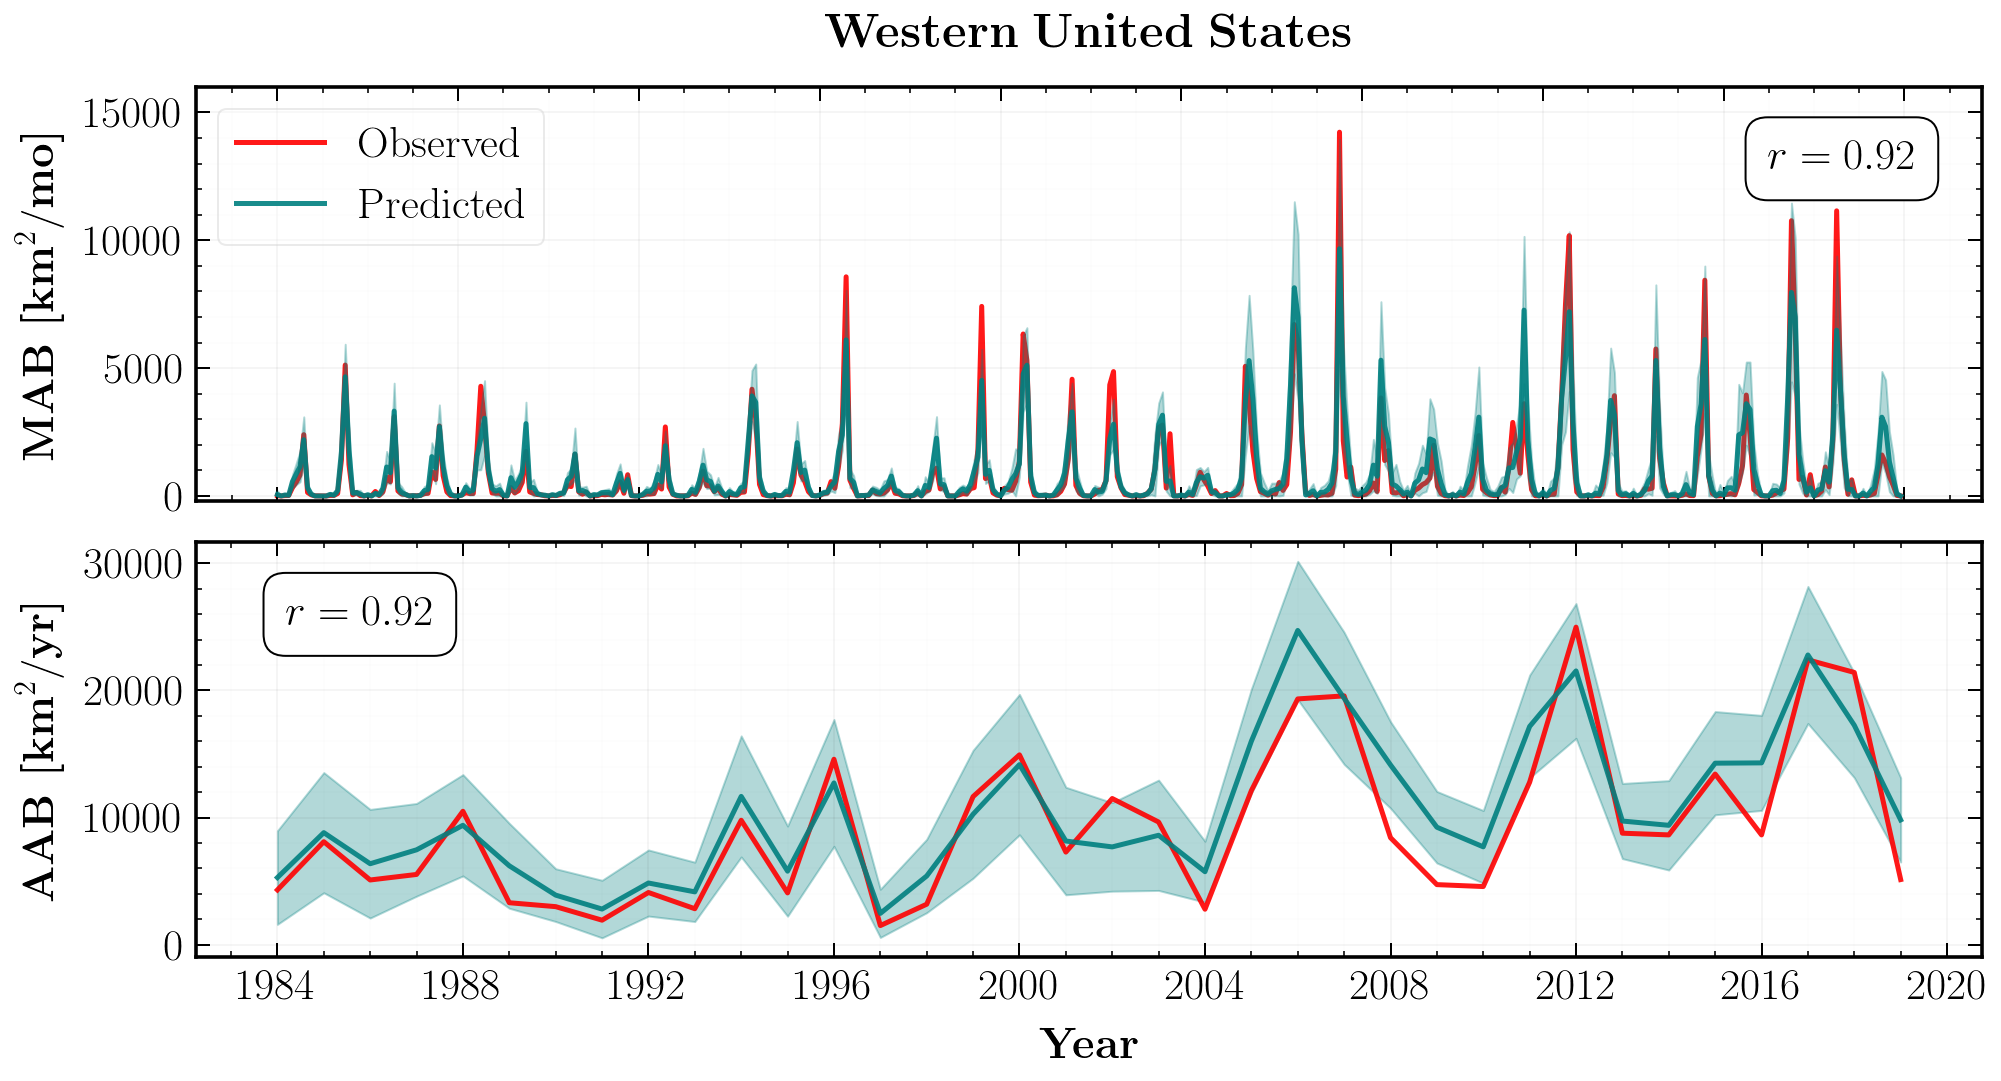

In [23]:
fig, ax= plt.subplots(2, 1, figsize=(16, 8))

ax[1].plot(yr_arr[:-1], np.sum(tot_ann_obs_size_arr, axis= 0), color= 'red');
ax[1].plot(yr_arr[:-1], tot_ann_pred_size_arr, color= 'teal'); #np.sum(ann_pred_arr, axis= 0)
ax[1].fill_between(yr_arr[:-1], tot_ann_pred_high_1sig_arr, tot_ann_pred_low_1sig_arr, color= 'teal', alpha= 0.3) #np.sum(ann_pred_high_1sig_arr, axis= 0)
ax[1].set_ylabel(r'{\bf AAB [${\bf km}^2/{\bf yr}$]}', fontsize= 22, labelpad= 10);
ax[1].set_xlabel(r'{\bf Year}', fontsize= 22);
ax[1].set_xticks((year_arr - 1984)*12);
ax[1].set_xticklabels(year_arr)
ax[1].text(0.05, 0.8, r'$r = %.2f$'%tot_ann_size_r, fontsize= 22, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[1].transAxes)
ax[1].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax[1].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[1].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');

fig.subplots_adjust(hspace= 0.1)

ax[0].plot(month_arr, np.sum(tot_mon_obs_size_arr, axis= 0), color= 'red', label= 'Observed', zorder= 1);
ax[0].plot(month_arr, tot_mon_pred_size_arr, color= 'teal', label= 'Predicted');
ax[0].fill_between(month_arr, tot_mon_pred_high_1sig_arr, tot_mon_pred_low_1sig_arr, color= 'teal', alpha= 0.3, zorder= 10)
ax[0].set_title(r'${\bf Western \ United \ States}$', fontsize= 24, pad= 20); #Western \ United \ States
ax[0].set_ylabel(r'{\bf MAB [${\bf km}^2/{\bf mo}$]}', fontsize= 22, labelpad= 10);
ax[0].set_ylim(-200, 16000);
ax[0].set_xticks((year_arr - 1984)*12);
ax[0].set_xticklabels([])
ax[0].text(0.88, 0.8, r'$r = %.2f$'%tot_mon_size_r, fontsize= 22, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[0].transAxes)
ax[0].legend(loc='upper left', frameon= True, fontsize= 22);
ax[0].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax[0].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[0].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#fig.savefig('../paper_plots/ml_fire_size_wus.pdf', bbox_inches='tight', dpi= 300);

In [60]:
# functions to include different time breaks

# ann_obs_arr= []
# ann_pred_arr= []
# ann_pred_high_1sig_arr= []
# ann_pred_low_1sig_arr= []
# mon_obs_arr= []
# mon_pred_arr= []
# mon_pred_high_1sig_arr= []
# mon_pred_low_1sig_arr= []

# ann_obs_arr.append(np.sum(tot_ann_obs_size_arr, axis= 0))
# ann_pred_arr.append(tot_ann_pred_size_arr)
# ann_pred_high_1sig_arr.append(tot_ann_pred_high_1sig_arr)
# ann_pred_low_1sig_arr.append(tot_ann_pred_low_1sig_arr)
# mon_obs_arr.append(np.sum(tot_mon_obs_size_arr, axis= 0))
# mon_pred_arr.append(tot_mon_pred_size_arr)
# mon_pred_high_1sig_arr.append(tot_mon_pred_high_1sig_arr)
# mon_pred_low_1sig_arr.append(tot_mon_pred_low_1sig_arr)

### 4.3 Regional sizes

In [57]:
startmon= 0
# totmonths= final_month - startmon
# month_arr= np.linspace(startmon, final_month - 1, totmonths, dtype= np.int64)
# year_arr= np.arange(1984, 2021, 4) #np.asarray([2006, 2009, 2012, 2015, 2018, 2021]) #np.asarray([2015, 2016, 2017, 2018, 2019, 2020])
# yr_arr= np.arange(0, tot_months + 1, 12) 

reg_name= {1: "Sierra Nevada", 2: "North Coast", 3: "Central Coast", 4: "South Coast", 5: "Pacific NW", 6: "Columbia Plateau", 7:"Northern Rockies", \
          8: "Middle Rockies", 9: "Southern Rockies", 10: "AM Semidesert", 11: "AZ/NM Mts.", 12: "IM Semidesert", 13: "IM Desert", 14: "Northern Great Plains", \
          15: "High Plains", 16: "Colorado Plateau", 17: "SW Tablelands", 18: "CH Desert"}
ind_grid_1= [[1, 2, 5], [6, 7, 8], [9, 11, 16]]
ind_grid_2= [[12, 13, 14], [10, 15, 17], [3, 4, 18]]

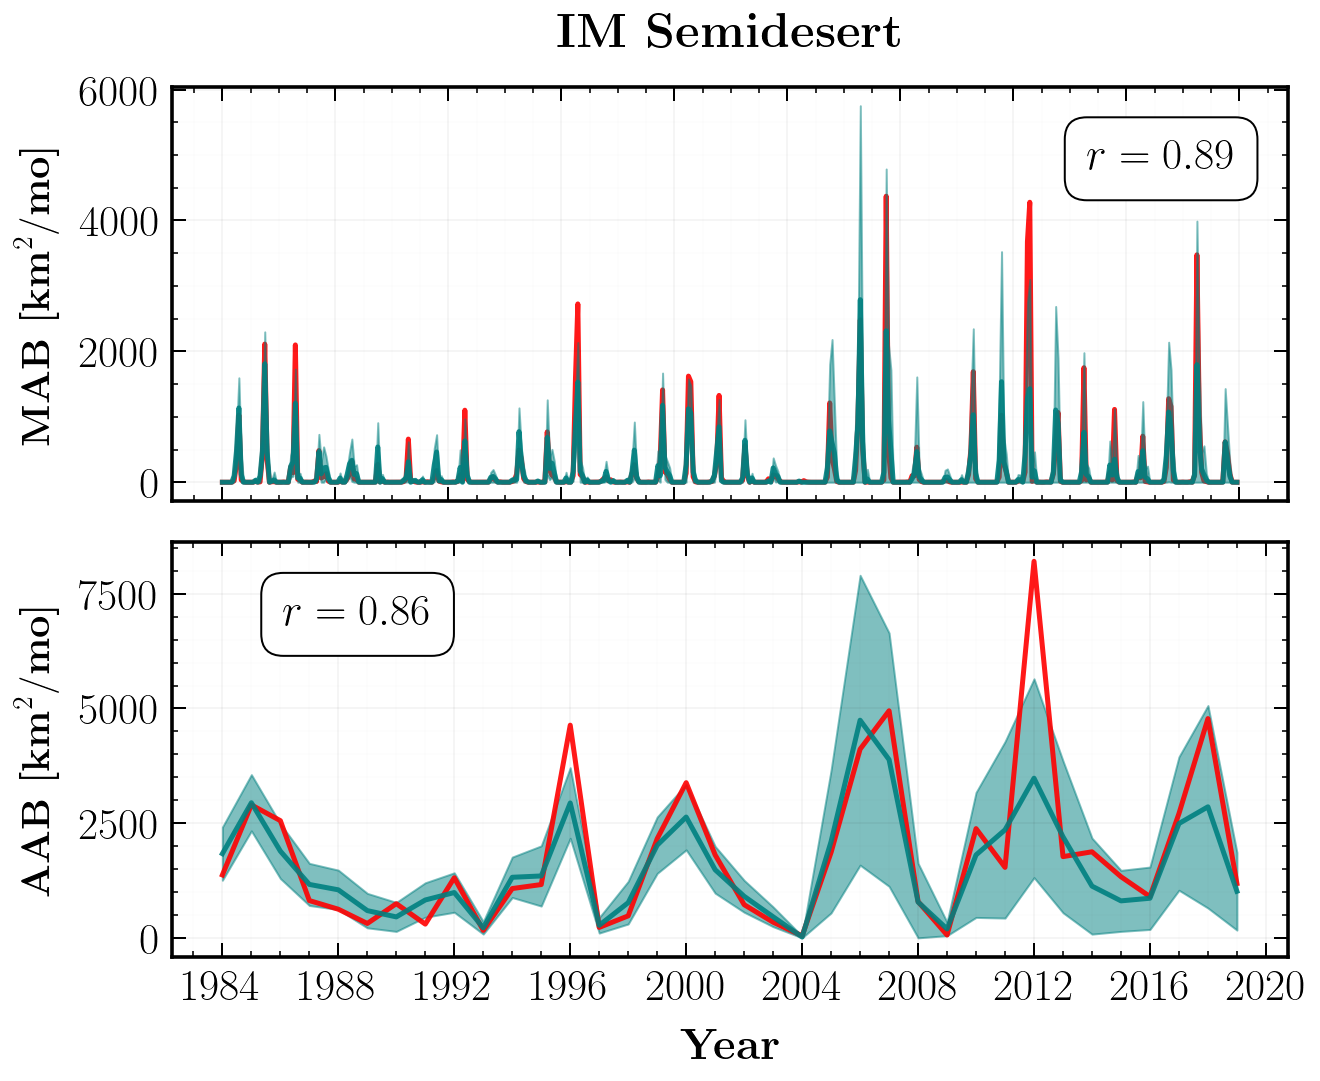

In [58]:
fig, ax= plt.subplots(2, 1, figsize=(10, 8))
pos_arr= [[0.8, 0.1], [0.82, 0.8]]

regindx= 12
pred_comb_sizes= np.append(reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['mean_size'].iloc[0:break_month], reg_gpd_ext_data_size_df.groupby('reg_indx').get_group(regindx)['mean_size'].iloc[break_month:])
pred_std= 0.5*(reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['high_1sig_size'] - \
                                                            reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['low_1sig_size'])
pred_ext_std= 0.5*(reg_gpd_ext_data_size_df.groupby('reg_indx').get_group(regindx)['high_1sig_size'] - \
                                                            reg_gpd_ext_data_size_df.groupby('reg_indx').get_group(regindx)['low_1sig_size'])
pred_comb_std= np.append(pred_std.iloc[0:break_month], pred_ext_std.iloc[break_month:])
pred_high_1sig= pred_comb_sizes + pred_comb_std
pred_low_1sig= pred_comb_sizes - pred_comb_std
pred_low_1sig[pred_low_1sig < 0]= 0
reg_mon_r_calib= stats.pearsonr(mon_burned_area(fire_file, regindx), pred_comb_sizes)[0]

obs_sizes= np.array([np.sum(mon_burned_area(fire_file, regindx)[yr_arr[i]:yr_arr[i+1]]).values for i in range(len(yr_arr) - 1)])
pred_ann_sizes, pred_ann_high_1sig, pred_ann_low_1sig= mon_to_ann_size_func(pred_comb_sizes, pred_high_1sig, pred_low_1sig, yr_arr)
reg_ann_r_calib= stats.pearsonr(obs_sizes, pred_ann_sizes)[0]
#rockies_obs_mab_arr.append(obs_sizes)
#rockies_pred_mab_arr.append(pred_ann_sizes)

ax[0].plot(month_arr, mon_burned_area(fire_file, regindx)[startmon:], color= 'red', lw= 2.5, label= 'Observed', zorder= 1); #, label= 'Observed'
ax[0].plot(month_arr, pred_comb_sizes[startmon:], color= 'teal', lw= 2.5); # label= 'Predicted'
ax[0].fill_between(month_arr, pred_high_1sig[startmon:], pred_low_1sig[startmon:], color= 'teal', alpha= 0.5, zorder= 10)
ax[0].set_ylabel(r'{\bf MAB [${\bf km}^2/{\bf mo}$]}', fontsize= 20, labelpad= 10);
ax[0].set_xticks((year_arr - startyr)*12 + startmon);
ax[0].set_xticklabels([])
ax[0].text(pos_arr[1][0], pos_arr[1][1], r'$r = %.2f$'%reg_mon_r_calib, fontsize= 22, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[0].transAxes)
ax[0].set_title(r'{\bf %s}'%reg_name[regindx], fontsize= 24, pad= 20);
#ax[0].legend(loc='upper left', frameon= True, fontsize= 20);
ax[0].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax[0].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[0].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');

fig.subplots_adjust(hspace= 0.1)

ax[1].plot(yr_arr[:-1], obs_sizes, color= 'red', lw= 2.5);
ax[1].plot(yr_arr[:-1], pred_ann_sizes, color= 'teal', lw= 2.5);
ax[1].fill_between(yr_arr[:-1], pred_ann_high_1sig, pred_ann_low_1sig, color= 'teal', alpha= 0.5);
ax[1].set_ylabel(r'{\bf AAB [${\bf km}^2/{\bf mo}$]}', fontsize= 20);
ax[1].set_xlabel(r'{\bf Year}', fontsize= 22);
ax[1].set_xticks((year_arr - startyr)*12 + startmon);
ax[1].set_xticklabels(year_arr)
ax[1].text(pos_arr[0][1], pos_arr[0][0], r'$r = %.2f$'%reg_ann_r_calib, fontsize= 22, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[1].transAxes)
#ax[1].legend(loc='upper left', frameon= True, fontsize= 20);
ax[1].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax[1].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[1].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#fig.savefig('../paper_plots/ml_fire_size_colplateau.pdf', bbox_inches='tight', dpi= 300); #bbox_inches='tight',

#### Monthly

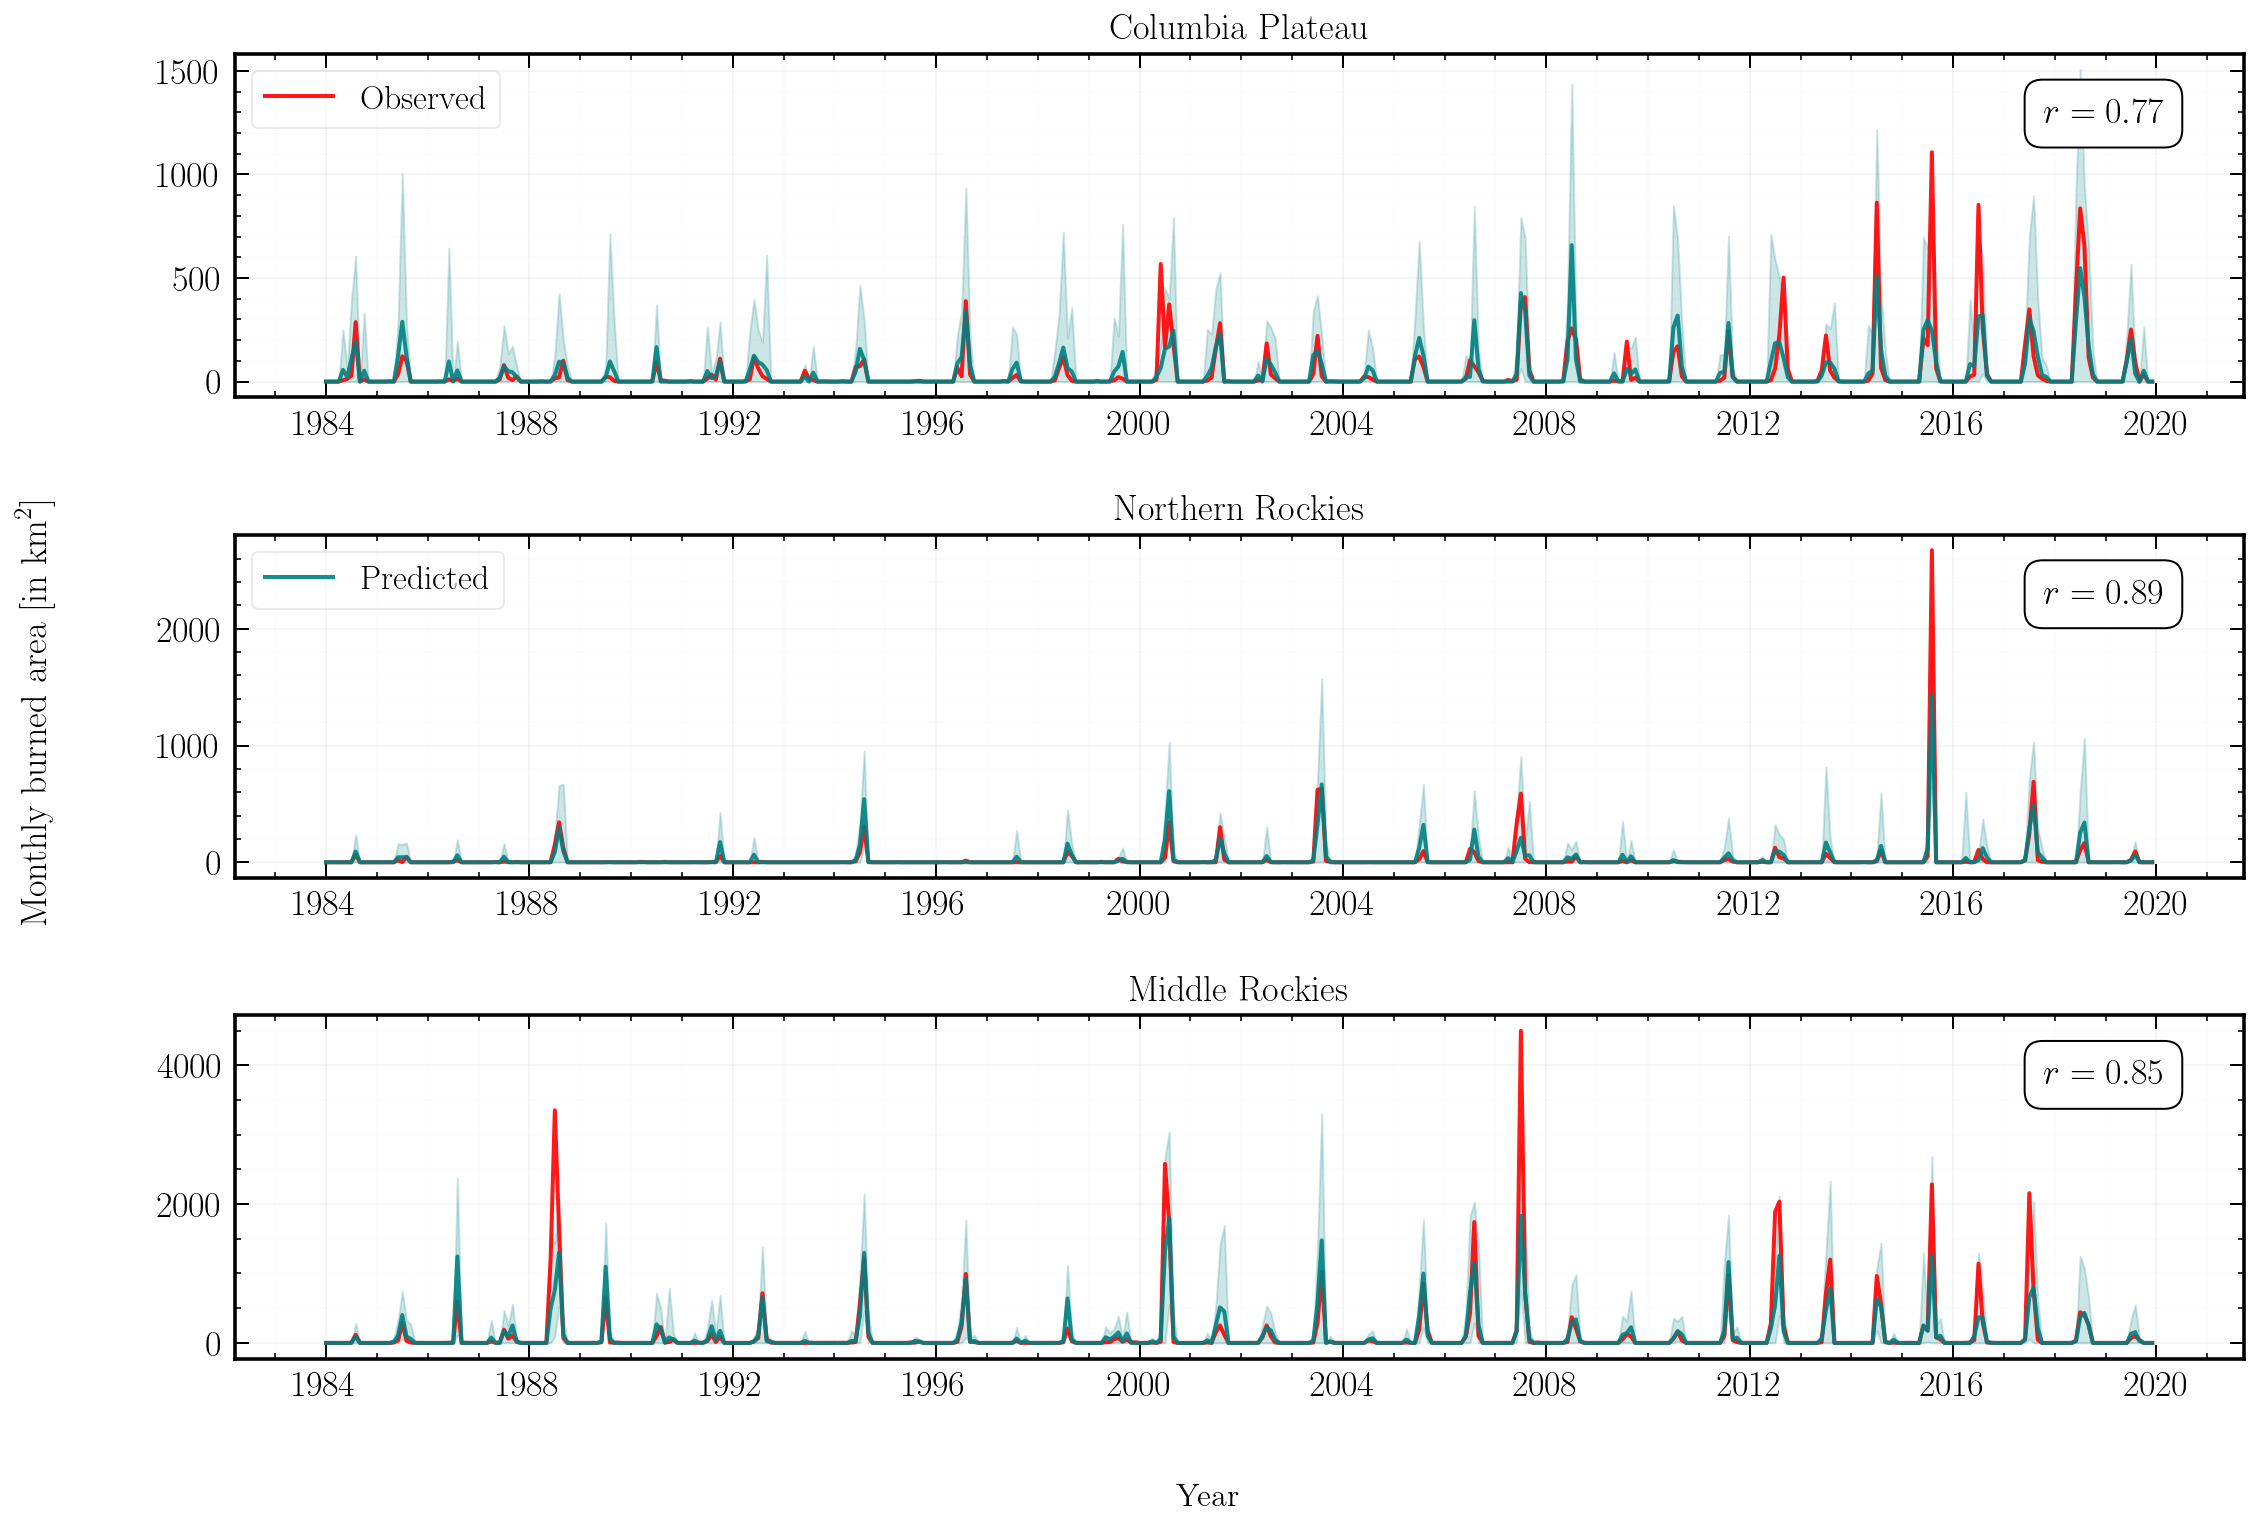

In [66]:
fig, ax= plt.subplots(3, 1, figsize=(18, 12))
#plt.suptitle(r'Monthly fire size', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly burned area [in ${\rm km}^2$]', va='center', rotation='vertical', fontsize= 18);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

j= 1
for i in range(3):
    regindx= ind_grid_1[j][i]
    reg_mon_r_calib= stats.pearsonr(mon_burned_area(fire_file, regindx), reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['mean_size'])[0]
        
    if (i==0):
        ax[i].plot(month_arr, mon_burned_area(fire_file, regindx)[startmon:], color= 'red', lw= 2, label= 'Observed');
        ax[i].legend(loc='upper left', frameon= True);
    else:
        ax[i].plot(month_arr, mon_burned_area(fire_file, regindx)[startmon:], color= 'red', lw= 2);
    if (i==1):
        ax[i].plot(month_arr, reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['mean_size'][startmon:], color= 'teal', lw= 2, label= 'Predicted');
        ax[i].legend(loc='upper left', frameon= True);
    else:
        ax[i].plot(month_arr, reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['mean_size'][startmon:], color= 'teal', lw= 2);
    ax[i].fill_between(month_arr, reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['high_1sig_size'][startmon:], reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['low_1sig_size'][startmon:], \
                                                                                                                             color= 'teal', alpha=0.2);
    ax[i].text(0.9, 0.8, r'$r = %.2f$'%reg_mon_r_calib, fontsize= 18, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[i].transAxes)
    ax[i].set_title(reg_name[regindx], fontsize= 18);
    ax[i].set_xticks((year_arr - 1984)*12 + startmon);
    ax[i].set_xticklabels(year_arr)
        #ax[i, j].set_yscale('log')
            
    fig.subplots_adjust(hspace= 0.4)
        #fig.minorticks_on()
    ax[i].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
    ax[i].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
    ax[i].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_grid_mon_fire_size_12km_gpd_nforest_%d.pdf'%(j+1), bbox_inches='tight');

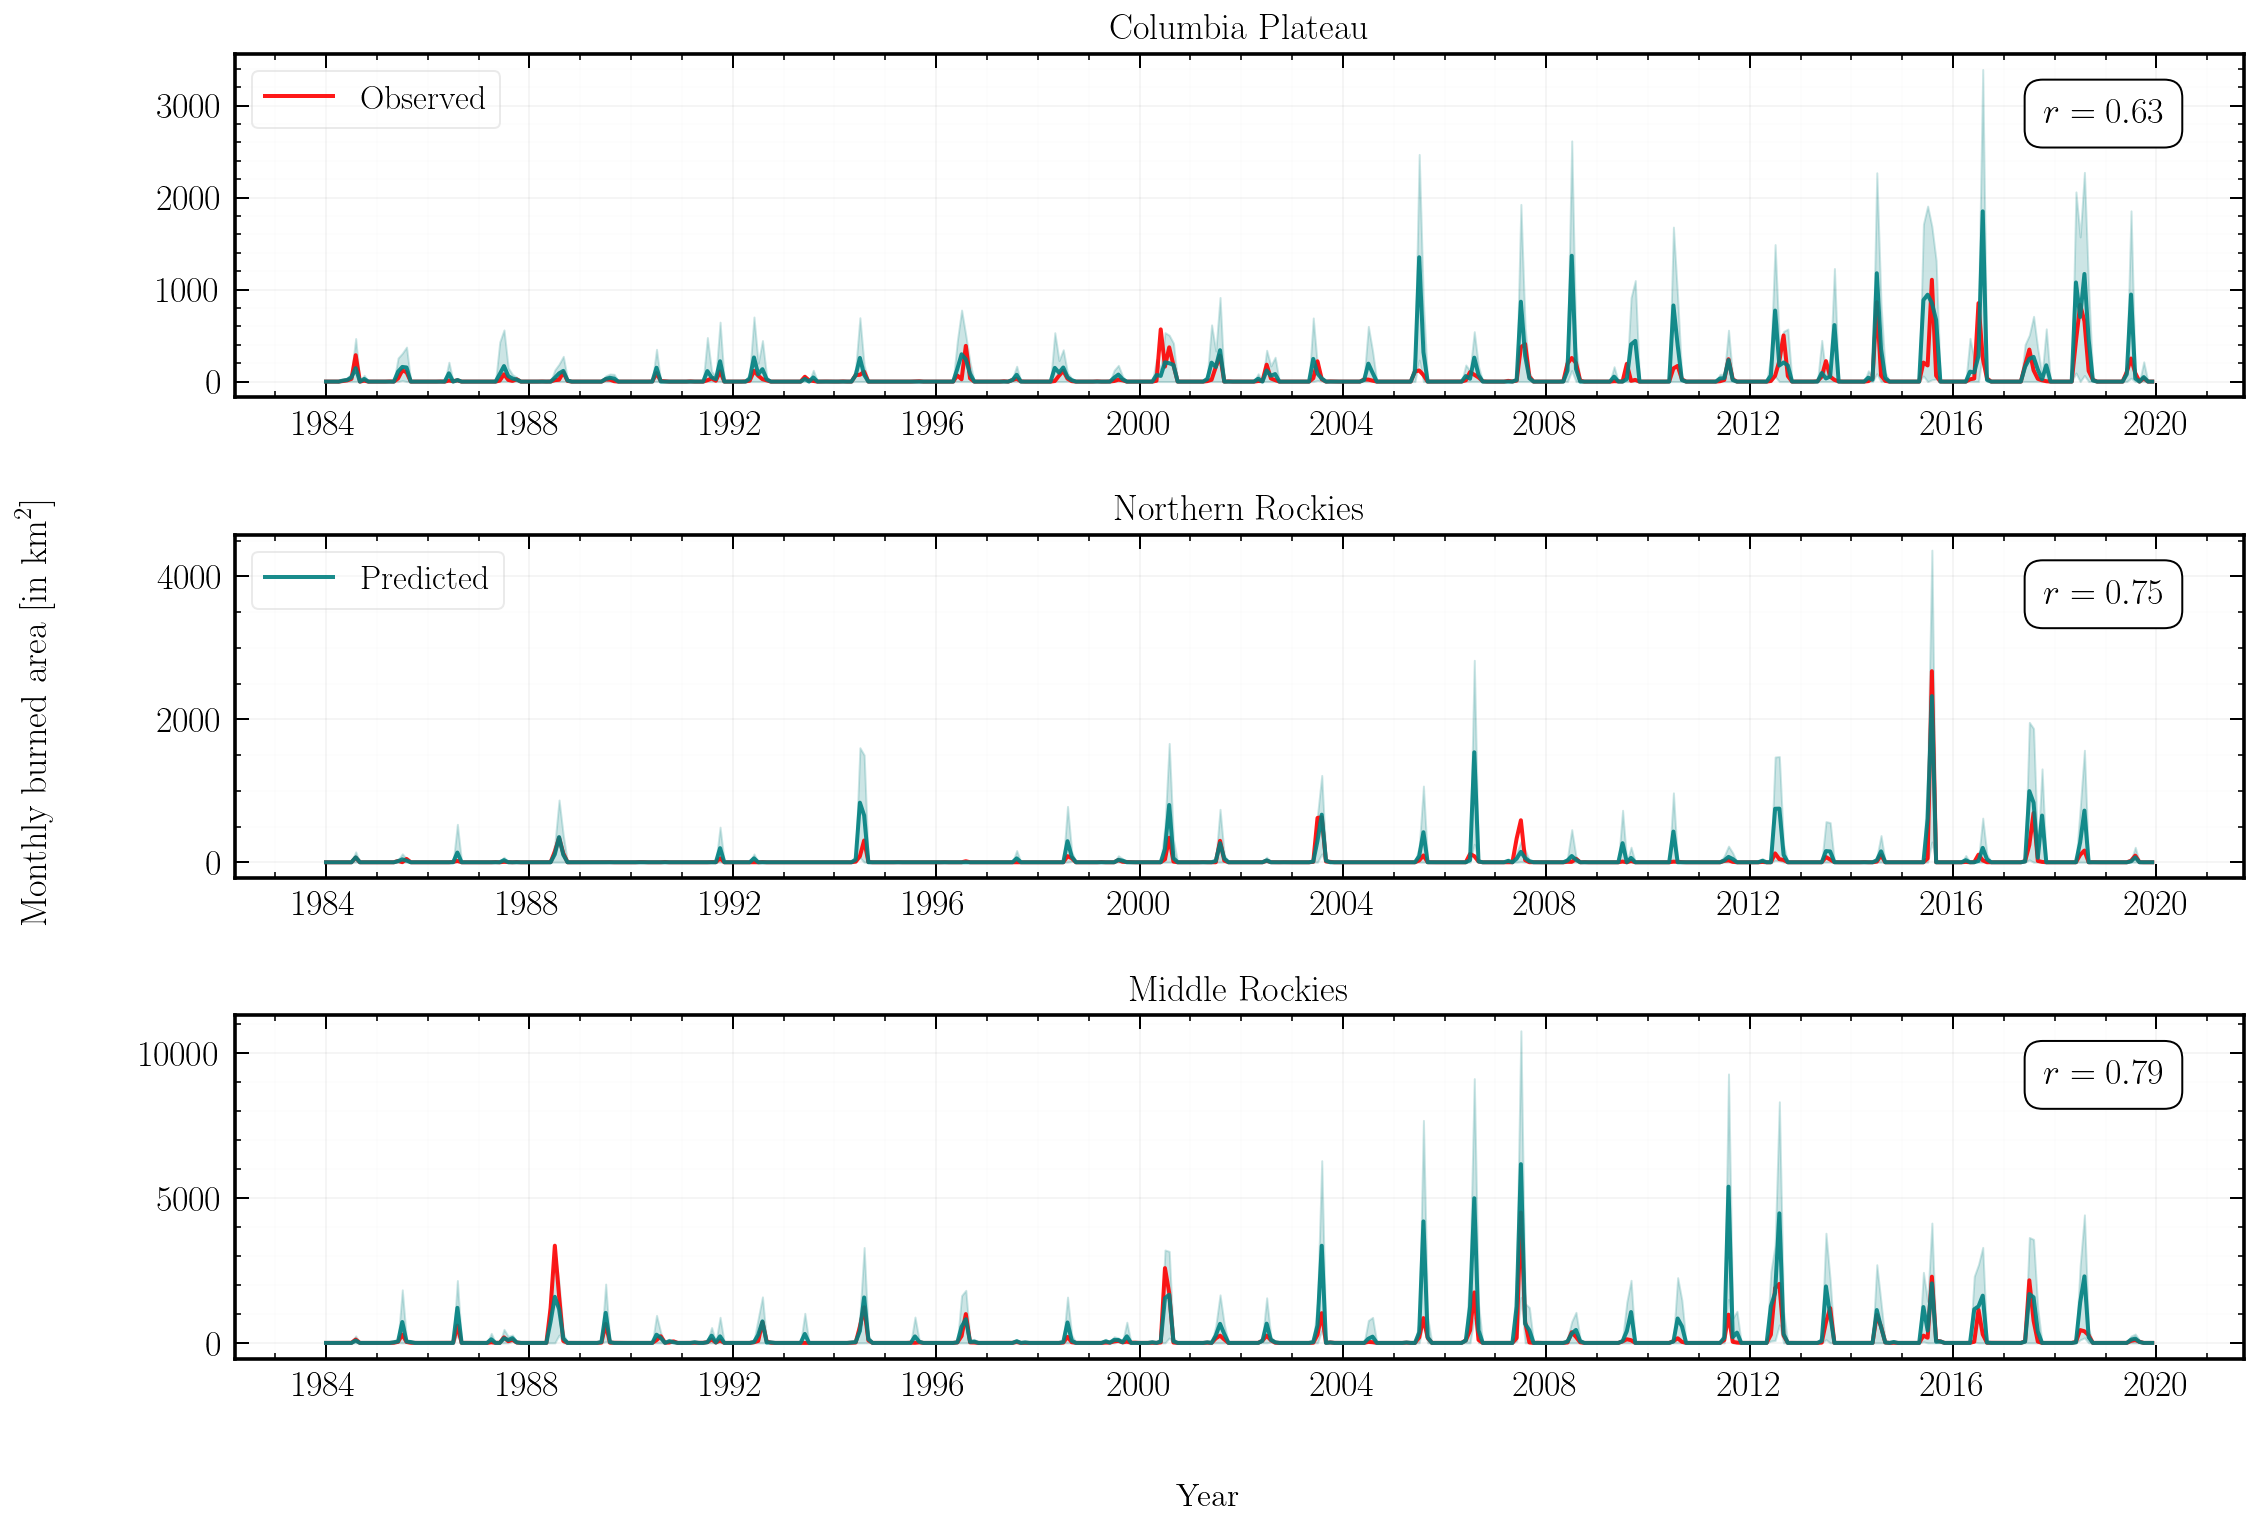

In [22]:
fig, ax= plt.subplots(3, 1, figsize=(18, 12))
#plt.suptitle(r'Monthly fire size', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly burned area [in ${\rm km}^2$]', va='center', rotation='vertical', fontsize= 18);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

j= 1
for i in range(3):
    regindx= ind_grid_1[j][i]
    pred_comb_sizes= np.append(reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['mean_size'].iloc[0:break_month], reg_gpd_ext_data_size_df.groupby('reg_indx').get_group(regindx)['mean_size'].iloc[break_month:])
    pred_std= 0.5*(reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['high_1sig_size'] - \
                                                            reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['low_1sig_size'])
    pred_ext_std= 0.5*(reg_gpd_ext_data_size_df.groupby('reg_indx').get_group(regindx)['high_1sig_size'] - \
                                                            reg_gpd_ext_data_size_df.groupby('reg_indx').get_group(regindx)['low_1sig_size'])
    pred_comb_std= np.append(pred_std.iloc[0:break_month], pred_ext_std.iloc[break_month:])

    pred_high_1sig= pred_comb_sizes + pred_comb_std
    pred_low_1sig= pred_comb_sizes - pred_comb_std
    pred_low_1sig[pred_low_1sig < 0]= 0
    reg_mon_r_calib= stats.pearsonr(mon_burned_area(fire_file, regindx), pred_comb_sizes)[0]
        
    if (i==0):
        ax[i].plot(month_arr, mon_burned_area(fire_file, regindx)[startmon:], color= 'red', lw= 2, label= 'Observed');
        ax[i].legend(loc='upper left', frameon= True);
    else:
        ax[i].plot(month_arr, mon_burned_area(fire_file, regindx)[startmon:], color= 'red', lw= 2);
    if (i==1):
        ax[i].plot(month_arr, pred_comb_sizes[startmon:], color= 'teal', lw= 2, label= 'Predicted');
        ax[i].legend(loc='upper left', frameon= True);
    else:
        ax[i].plot(month_arr, pred_comb_sizes[startmon:], color= 'teal', lw= 2);
    ax[i].fill_between(month_arr, pred_high_1sig[startmon:], pred_low_1sig[startmon:], color= 'teal', alpha=0.2);
    ax[i].text(0.9, 0.8, r'$r = %.2f$'%reg_mon_r_calib, fontsize= 18, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[i].transAxes)
    ax[i].set_title(reg_name[regindx], fontsize= 18);
    ax[i].set_xticks((year_arr - 1984)*12 + startmon);
    ax[i].set_xticklabels(year_arr)
        #ax[i, j].set_yscale('log')
            
    fig.subplots_adjust(hspace= 0.4)
        #fig.minorticks_on()
    ax[i].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
    ax[i].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
    ax[i].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_grid_mon_fire_size_12km_combined_ml_freq_data_loc_%d.pdf'%(j+1), bbox_inches='tight');

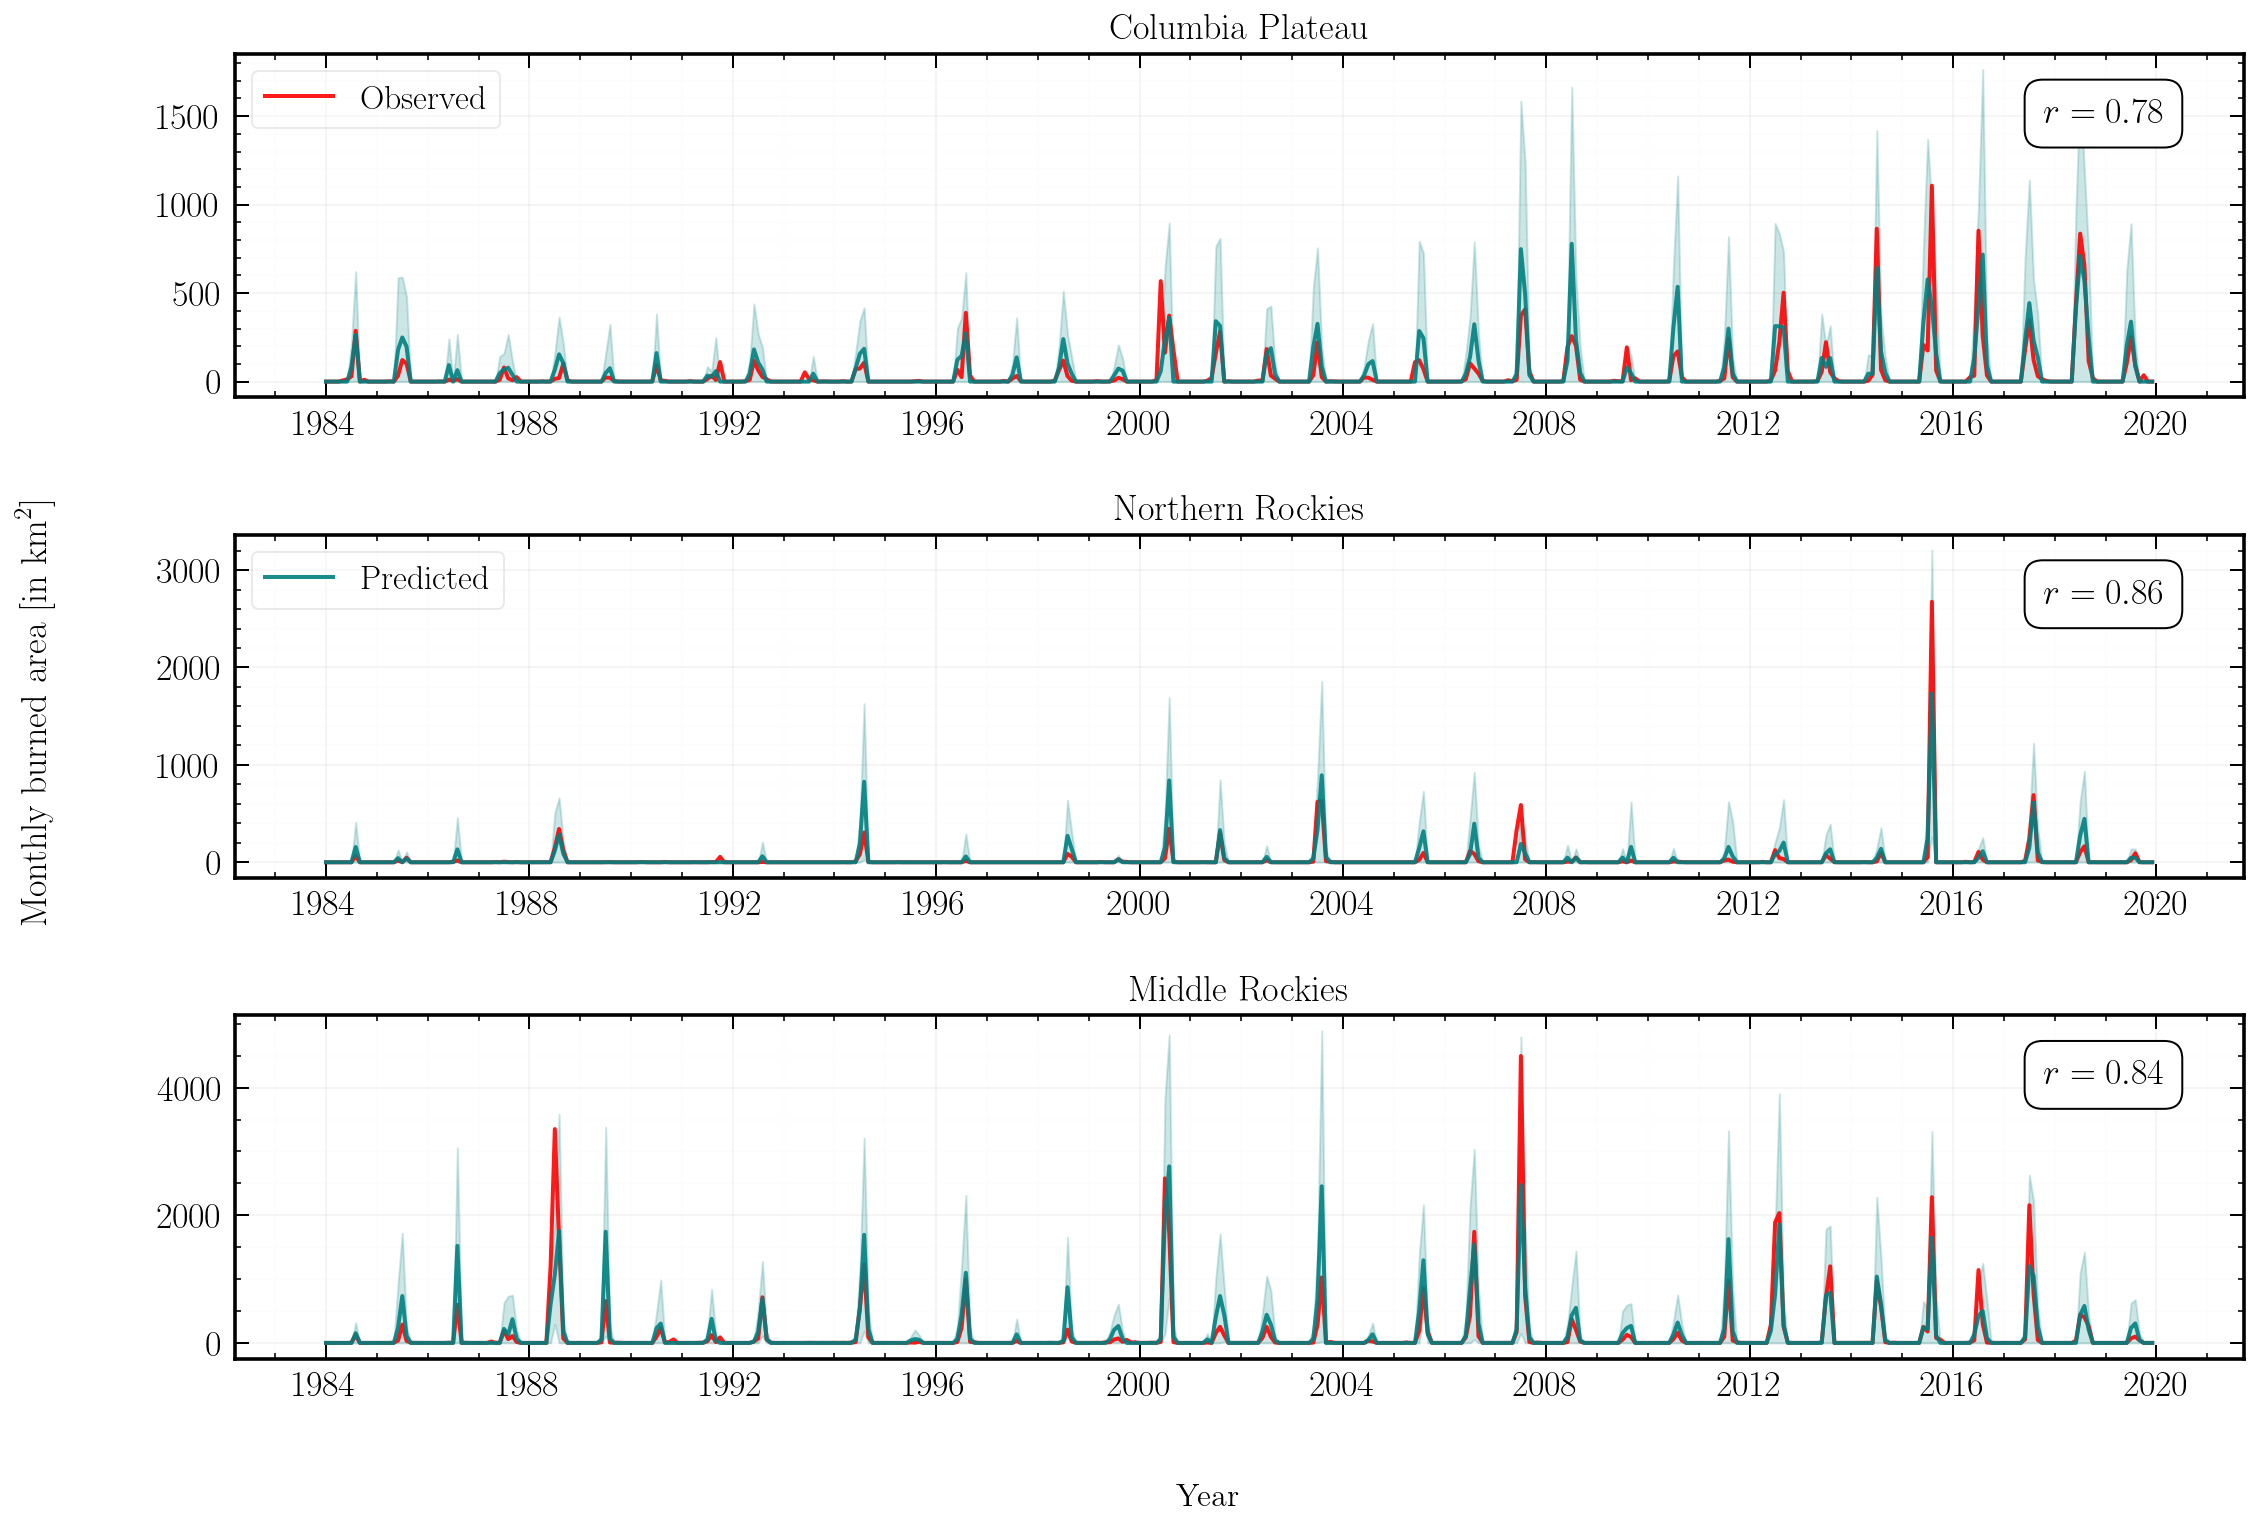

In [123]:
fig, ax= plt.subplots(3, 1, figsize=(18, 12))
#plt.suptitle(r'Monthly fire size', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly burned area [in ${\rm km}^2$]', va='center', rotation='vertical', fontsize= 18);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

j= 1
for i in range(3):
    regindx= ind_grid_1[j][i]
    pred_comb_sizes= np.append(reg_ml_gpd_size_df.groupby('reg_indx').get_group(regindx)['mean_size'].iloc[0:break_month], reg_ml_gpd_ext_size_df.groupby('reg_indx').get_group(regindx)['mean_size'].iloc[break_month:])
    pred_std= 0.5*(reg_ml_gpd_size_df.groupby('reg_indx').get_group(regindx)['high_1sig_size'] - \
                                                            reg_ml_gpd_size_df.groupby('reg_indx').get_group(regindx)['low_1sig_size'])
    pred_ext_std= 0.5*(reg_ml_gpd_ext_size_df.groupby('reg_indx').get_group(regindx)['high_1sig_size'] - \
                                                            reg_ml_gpd_ext_size_df.groupby('reg_indx').get_group(regindx)['low_1sig_size'])
    pred_comb_std= np.append(pred_std.iloc[0:break_month], pred_ext_std.iloc[break_month:])

    pred_high_1sig= pred_comb_sizes + pred_comb_std
    pred_low_1sig= pred_comb_sizes - pred_comb_std
    pred_low_1sig[pred_low_1sig < 0]= 0
    reg_mon_r_calib= stats.pearsonr(mon_burned_area(fire_file, regindx), pred_comb_sizes)[0]
        
    if (i==0):
        ax[i].plot(month_arr, mon_burned_area(fire_file, regindx)[startmon:], color= 'red', lw= 2, label= 'Observed');
        ax[i].legend(loc='upper left', frameon= True);
    else:
        ax[i].plot(month_arr, mon_burned_area(fire_file, regindx)[startmon:], color= 'red', lw= 2);
    if (i==1):
        ax[i].plot(month_arr, pred_comb_sizes[startmon:], color= 'teal', lw= 2, label= 'Predicted');
        ax[i].legend(loc='upper left', frameon= True);
    else:
        ax[i].plot(month_arr, pred_comb_sizes[startmon:], color= 'teal', lw= 2);
    ax[i].fill_between(month_arr, pred_high_1sig[startmon:], pred_low_1sig[startmon:], color= 'teal', alpha=0.2);
    ax[i].text(0.9, 0.8, r'$r = %.2f$'%reg_mon_r_calib, fontsize= 18, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[i].transAxes)
    ax[i].set_title(reg_name[regindx], fontsize= 18);
    ax[i].set_xticks((year_arr - 1984)*12 + startmon);
    ax[i].set_xticklabels(year_arr)
        #ax[i, j].set_yscale('log')
            
    fig.subplots_adjust(hspace= 0.4)
        #fig.minorticks_on()
    ax[i].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
    ax[i].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
    ax[i].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_grid_mon_fire_size_12km_combined_data_freq_ml_loc_%d.pdf'%(j+1), bbox_inches='tight');

#### Annual

100%|█████████████████████████████████████████████| 3/3 [00:57<00:00, 19.20s/it]


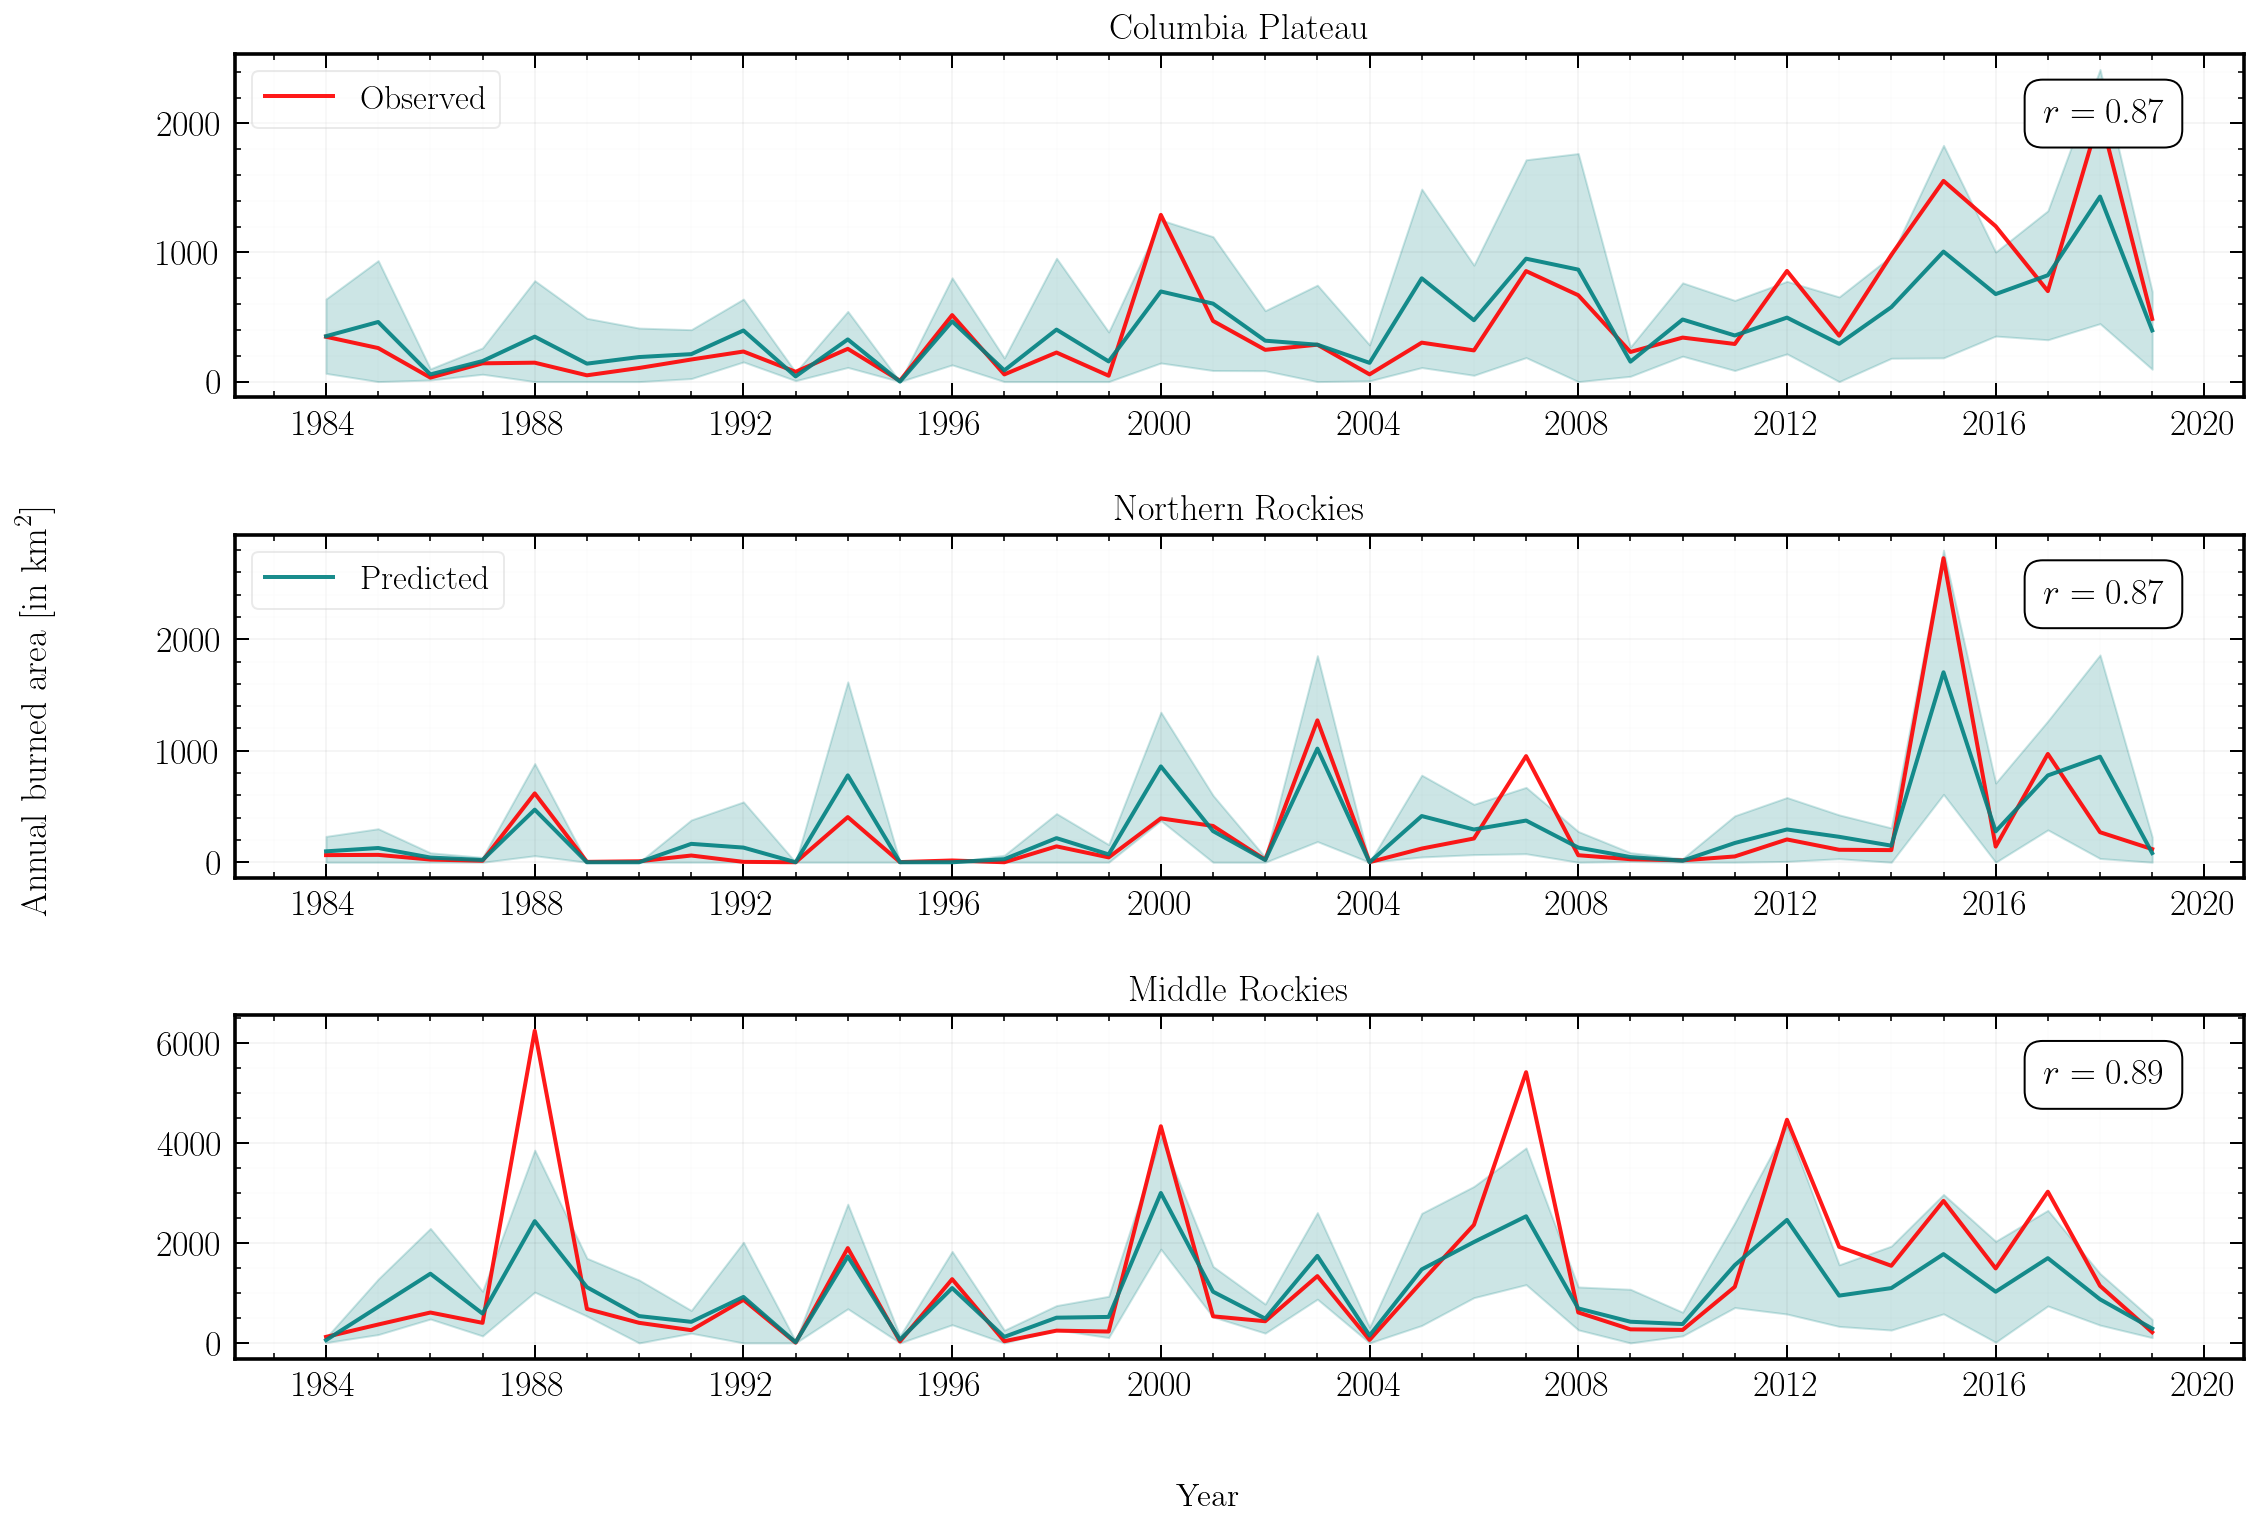

In [89]:
fig, ax= plt.subplots(3, 1, figsize=(18, 12))
#plt.suptitle(r'Monthly fire size', fontsize= 18);
fig.text(0.04, 0.5, r'Annual burned area [in ${\rm km}^2$]', va='center', rotation='vertical', fontsize= 18);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

j= 1
for i in tqdm(range(3)):
    regindx= ind_grid_1[j][i]
    obs_sizes= np.array([np.sum(mon_burned_area(fire_file, regindx)[yr_arr[i]:yr_arr[i+1]]).values for i in range(len(yr_arr) - 1)])
    pred_sizes, pred_high_1sig, pred_low_1sig= mon_to_ann_size_func(reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['mean_size'], \
                                                                reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['high_1sig_size'],
                                                                reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['low_1sig_size'], yr_arr)
    reg_ann_r_calib= stats.pearsonr(obs_sizes, pred_sizes)[0]
        
    if (i==0):
        ax[i].plot(yr_arr[:-1], obs_sizes, color= 'red', lw= 2, label= 'Observed');
        ax[i].legend(loc='upper left', frameon= True);
    else:
        ax[i].plot(yr_arr[:-1], obs_sizes, color= 'red', lw= 2);
    if (i==1):
        ax[i].plot(yr_arr[:-1], pred_sizes, color= 'teal', lw= 2, label= 'Predicted');
        ax[i].legend(loc='upper left', frameon= True);
    else:
        ax[i].plot(yr_arr[:-1], pred_sizes, color= 'teal', lw= 2);
    ax[i].fill_between(yr_arr[:-1], pred_high_1sig, pred_low_1sig, color= 'teal', alpha=0.2);
    ax[i].text(0.9, 0.8, r'$r = %.2f$'%reg_ann_r_calib, fontsize= 18, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[i].transAxes)
    ax[i].set_title(reg_name[regindx], fontsize= 18);
    ax[i].set_xticks((year_arr - 1984)*12);
    ax[i].set_xticklabels(year_arr)
        #ax[i, j].set_yscale('log')
            
    fig.subplots_adjust(hspace= 0.4)
        #fig.minorticks_on()
    ax[i].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
    ax[i].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
    ax[i].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_grid_ann_fire_size_12km_gpd_nforest_%d.pdf'%(j+1), bbox_inches='tight');

100%|█████████████████████████████████████████████| 3/3 [00:56<00:00, 18.96s/it]


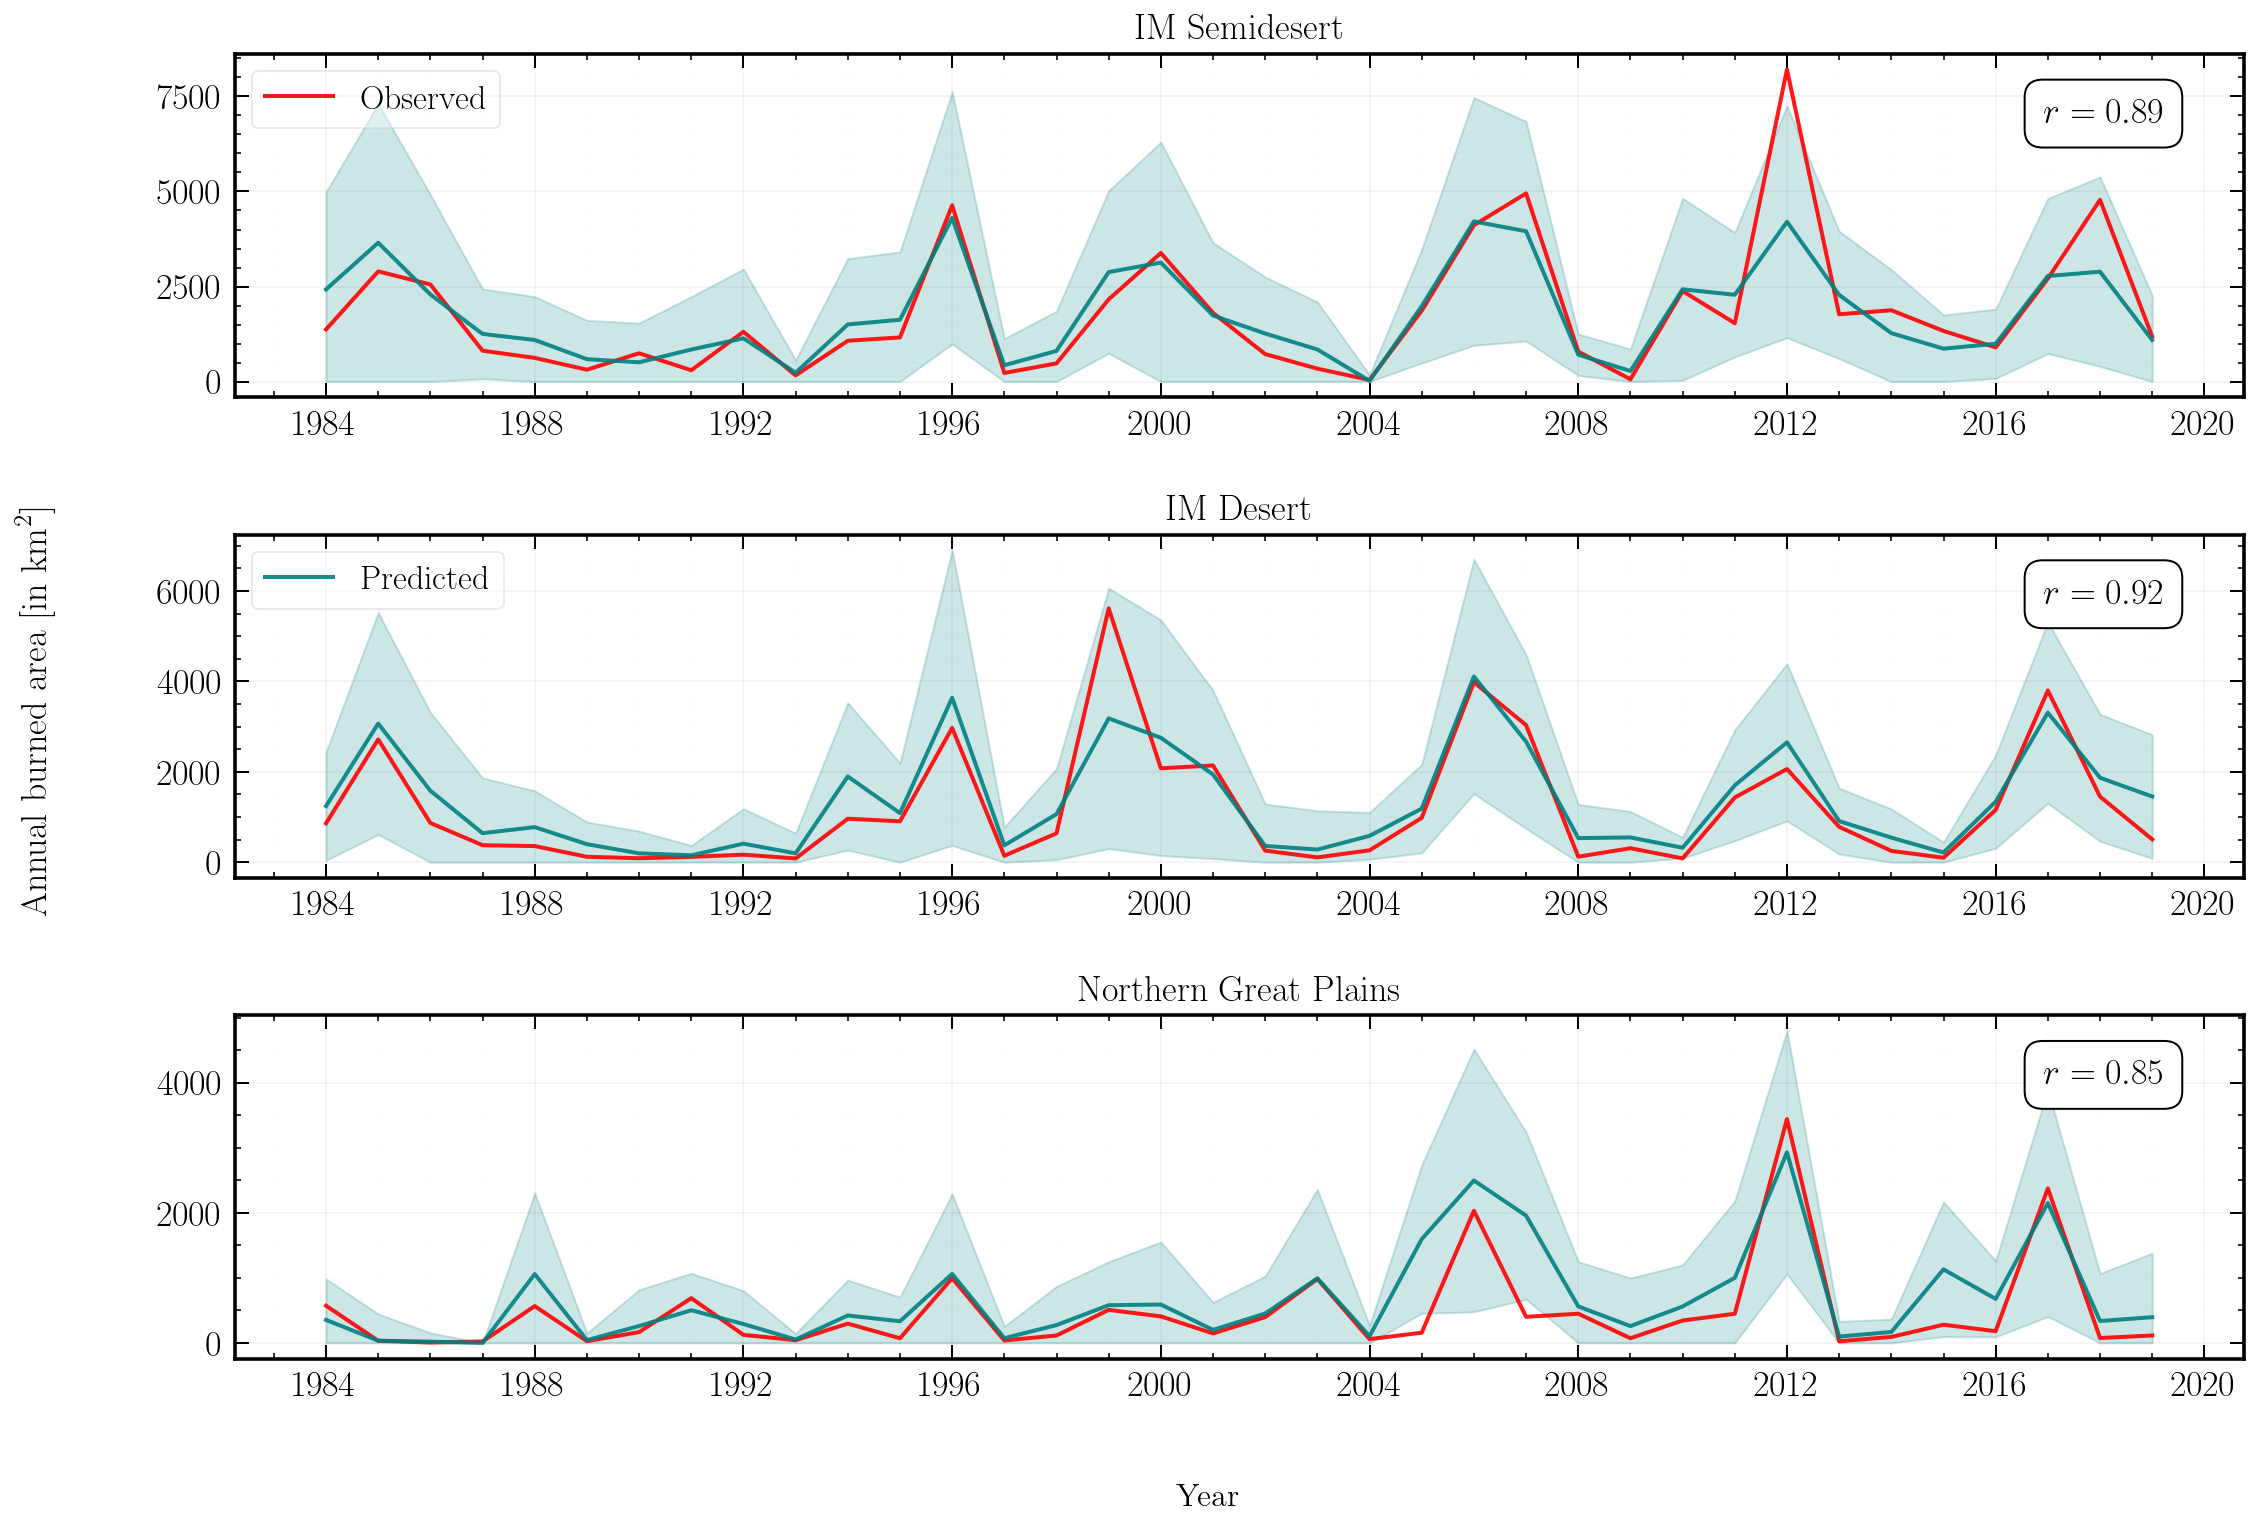

In [196]:
fig, ax= plt.subplots(3, 1, figsize=(18, 12))
#plt.suptitle(r'Monthly fire size', fontsize= 18);
fig.text(0.04, 0.5, r'Annual burned area [in ${\rm km}^2$]', va='center', rotation='vertical', fontsize= 18);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

j= 0
for i in tqdm(range(3)):
    regindx= ind_grid_2[j][i]
    obs_sizes= np.array([np.sum(mon_burned_area(fire_file, regindx)[yr_arr[i]:yr_arr[i+1]]).values for i in range(len(yr_arr) - 1)])
    pred_comb_sizes= np.append(reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['mean_size'].iloc[0:break_month], reg_gpd_ext_data_size_df.groupby('reg_indx').get_group(regindx)['mean_size'].iloc[break_month:])
    pred_sizes, pred_high_1sig, pred_low_1sig= mon_to_ann_size_func(pred_comb_sizes, \
                                                                reg_gpd_ext_data_size_df.groupby('reg_indx').get_group(regindx)['high_1sig_size'],
                                                                reg_gpd_ext_data_size_df.groupby('reg_indx').get_group(regindx)['low_1sig_size'], yr_arr)
    reg_ann_r_calib= stats.pearsonr(obs_sizes, pred_sizes)[0]
        
    if (i==0):
        ax[i].plot(yr_arr[:-1], obs_sizes, color= 'red', lw= 2, label= 'Observed');
        ax[i].legend(loc='upper left', frameon= True);
    else:
        ax[i].plot(yr_arr[:-1], obs_sizes, color= 'red', lw= 2);
    if (i==1):
        ax[i].plot(yr_arr[:-1], pred_sizes, color= 'teal', lw= 2, label= 'Predicted');
        ax[i].legend(loc='upper left', frameon= True);
    else:
        ax[i].plot(yr_arr[:-1], pred_sizes, color= 'teal', lw= 2);
    ax[i].fill_between(yr_arr[:-1], pred_high_1sig, pred_low_1sig, color= 'teal', alpha=0.2);
    ax[i].text(0.9, 0.8, r'$r = %.2f$'%reg_ann_r_calib, fontsize= 18, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[i].transAxes)
    ax[i].set_title(reg_name[regindx], fontsize= 18);
    ax[i].set_xticks((year_arr - 1984)*12);
    ax[i].set_xticklabels(year_arr)
        #ax[i, j].set_yscale('log')
            
    fig.subplots_adjust(hspace= 0.4)
        #fig.minorticks_on()
    ax[i].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
    ax[i].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
    ax[i].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_grid_ann_fire_size_12km_combined_ml_freq_data_loc_%d.pdf'%(j+1), bbox_inches='tight');

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:57<00:00, 19.03s/it]


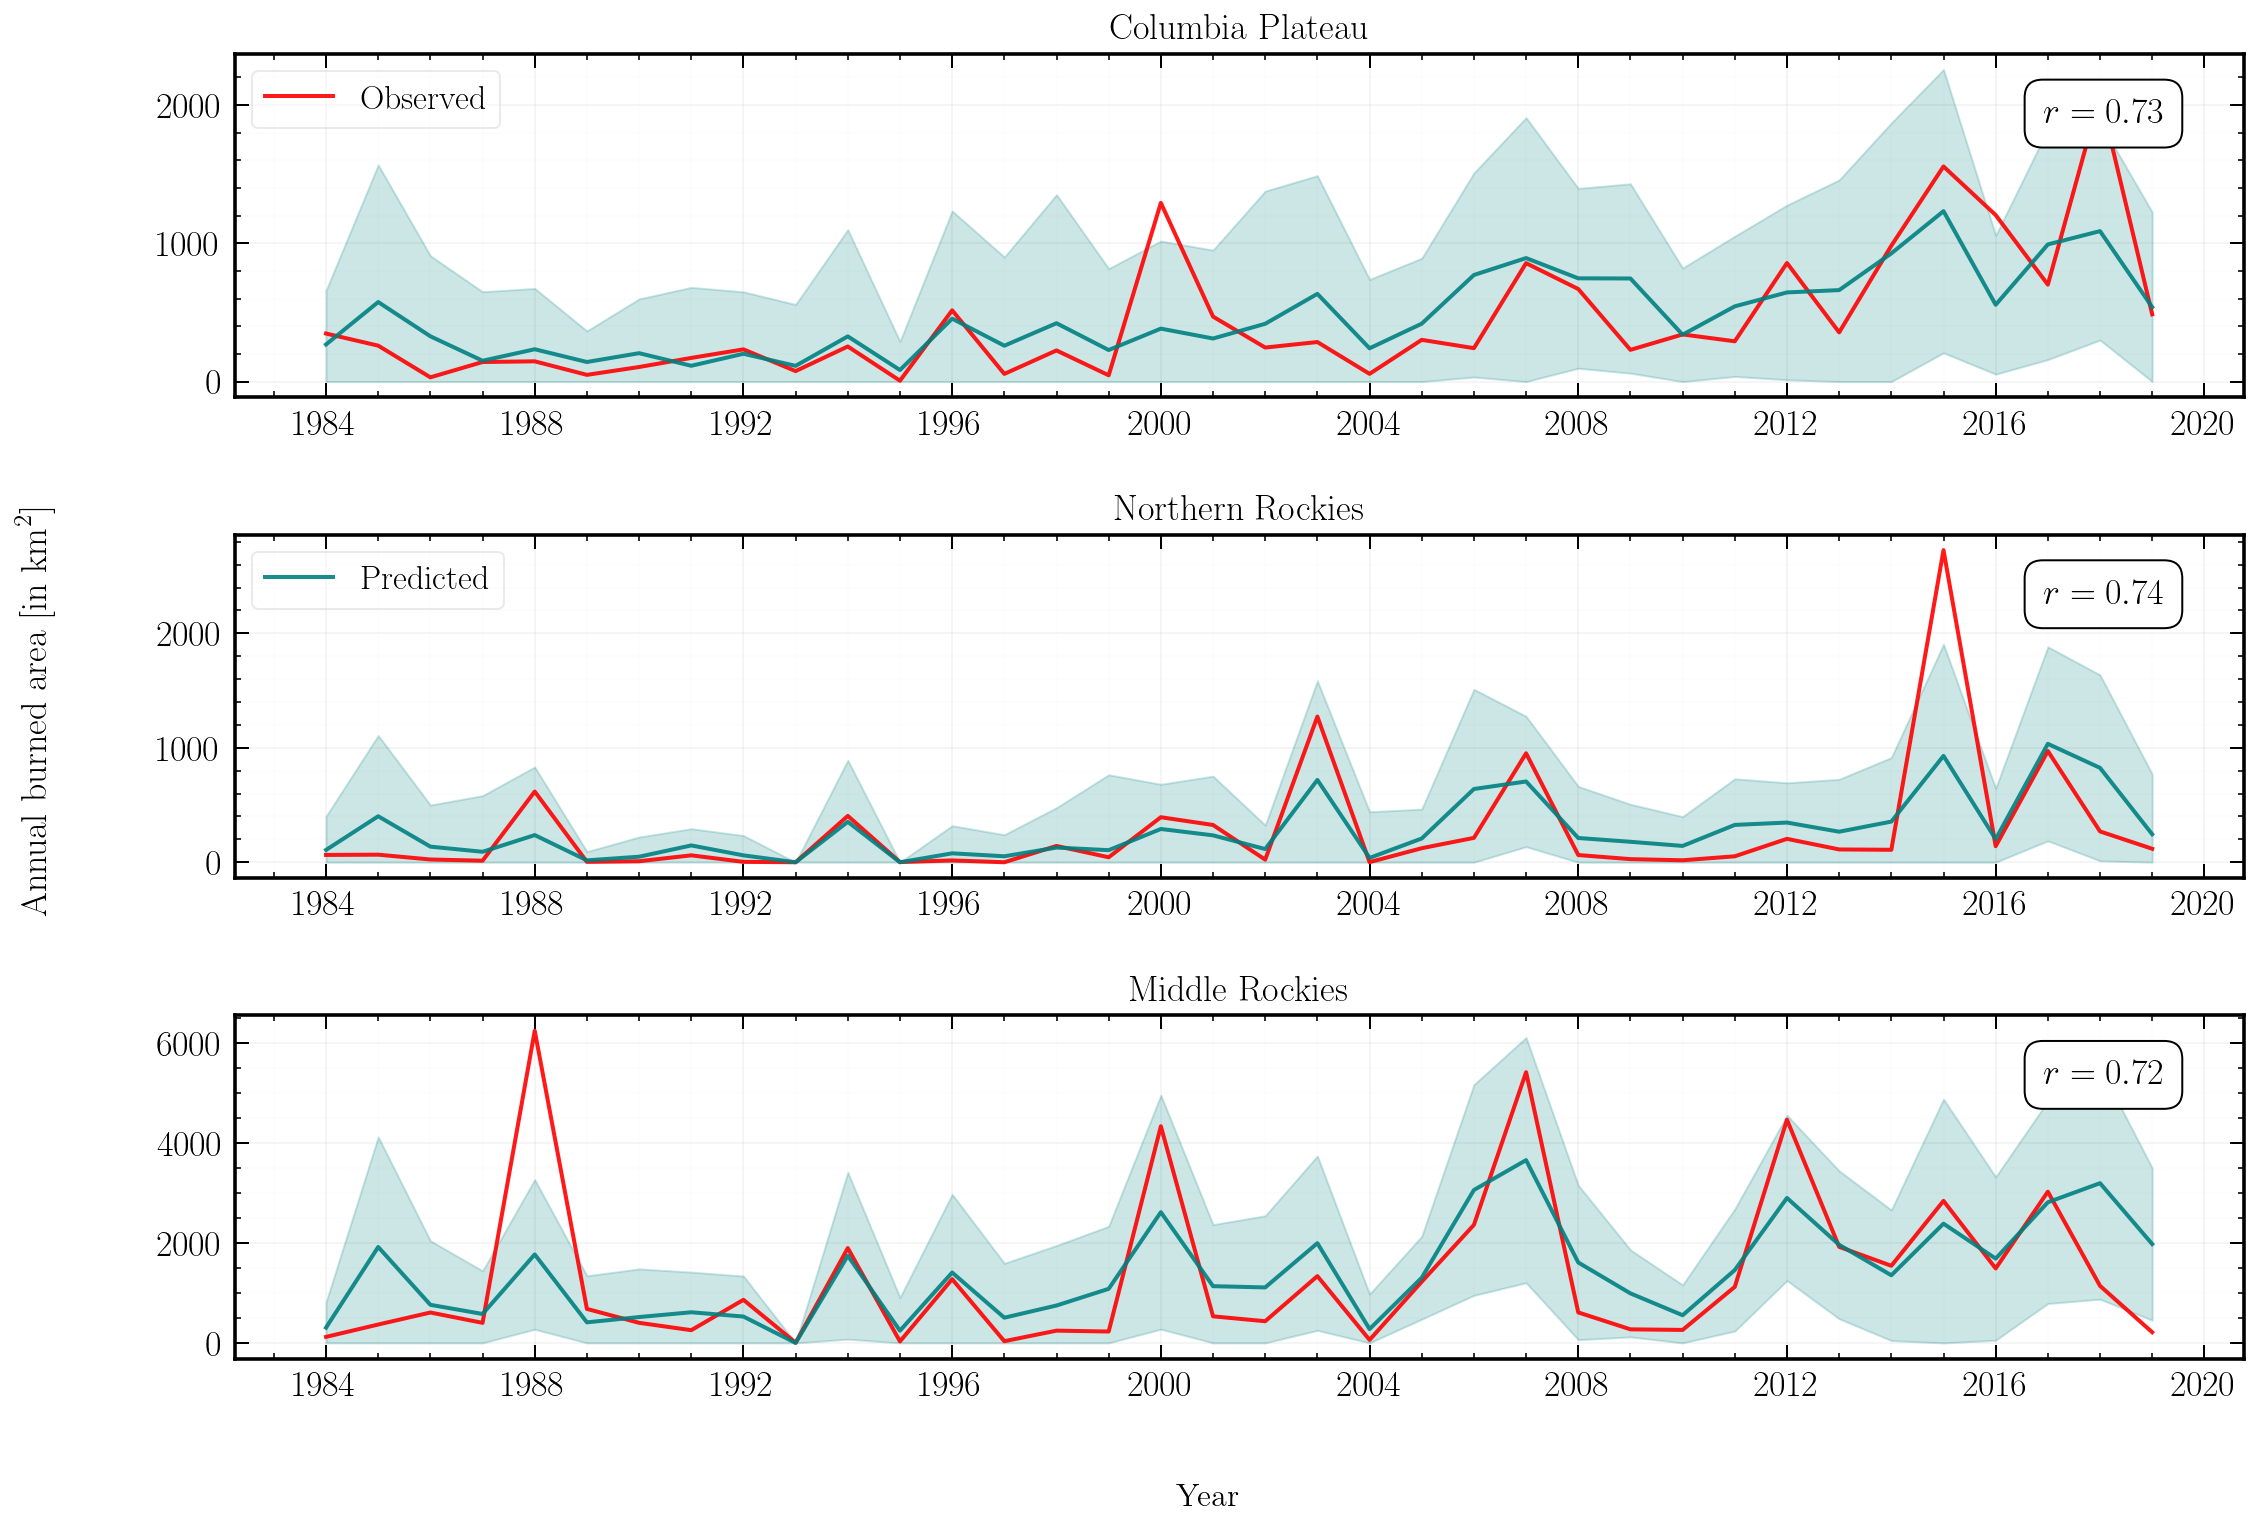

In [15]:
fig, ax= plt.subplots(3, 1, figsize=(18, 12))
#plt.suptitle(r'Monthly fire size', fontsize= 18);
fig.text(0.04, 0.5, r'Annual burned area [in ${\rm km}^2$]', va='center', rotation='vertical', fontsize= 18);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

j= 1
for i in tqdm(range(3)):
    regindx= ind_grid_1[j][i]
    obs_sizes= np.array([np.sum(mon_burned_area(fire_file, regindx)[yr_arr[i]:yr_arr[i+1]]).values for i in range(len(yr_arr) - 1)])
    pred_comb_sizes= np.append(reg_ml_gpd_size_df.groupby('reg_indx').get_group(regindx)['mean_size'].iloc[0:break_month], reg_ml_gpd_ext_size_df.groupby('reg_indx').get_group(regindx)['mean_size'].iloc[break_month:])
    pred_sizes, pred_high_1sig, pred_low_1sig= mon_to_ann_size_func(pred_comb_sizes, \
                                                                reg_ml_gpd_ext_size_df.groupby('reg_indx').get_group(regindx)['high_1sig_size'],
                                                                reg_ml_gpd_ext_size_df.groupby('reg_indx').get_group(regindx)['low_1sig_size'], yr_arr)
    reg_ann_r_calib= stats.pearsonr(obs_sizes, pred_sizes)[0]
        
    if (i==0):
        ax[i].plot(yr_arr[:-1], obs_sizes, color= 'red', lw= 2, label= 'Observed');
        ax[i].legend(loc='upper left', frameon= True);
    else:
        ax[i].plot(yr_arr[:-1], obs_sizes, color= 'red', lw= 2);
    if (i==1):
        ax[i].plot(yr_arr[:-1], pred_sizes, color= 'teal', lw= 2, label= 'Predicted');
        ax[i].legend(loc='upper left', frameon= True);
    else:
        ax[i].plot(yr_arr[:-1], pred_sizes, color= 'teal', lw= 2);
    ax[i].fill_between(yr_arr[:-1], pred_high_1sig, pred_low_1sig, color= 'teal', alpha=0.2);
    ax[i].text(0.9, 0.8, r'$r = %.2f$'%reg_ann_r_calib, fontsize= 18, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[i].transAxes)
    ax[i].set_title(reg_name[regindx], fontsize= 18);
    ax[i].set_xticks((year_arr - 1984)*12);
    ax[i].set_xticklabels(year_arr)
        #ax[i, j].set_yscale('log')
            
    fig.subplots_adjust(hspace= 0.4)
        #fig.minorticks_on()
    ax[i].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
    ax[i].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
    ax[i].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_grid_ann_fire_size_12km_combined_ml_freq_ml_loc_%d.pdf'%(j+1), bbox_inches='tight');

### 4.4 CDF: monthly burned area

In [123]:
obssizes_arr= []
predsizes_gpd_arr= []
predsizes_lognorm_gpd_arr= []
predsizes_data_arr= []

for r in tqdm(range(n_regions)):
    obssizes_arr.append(mon_burned_area(fire_file, r+1))
    predsizes_gpd_arr.append(np.append(reg_gpd_data_size_df.groupby('reg_indx').get_group(r+1)['mean_size'].iloc[0:break_month], \
                                               reg_gpd_ext_data_size_df.groupby('reg_indx').get_group(r+1)['mean_size'].iloc[break_month:]))
    predsizes_lognorm_gpd_arr.append(np.append(reg_lognorm_gpd_data_size_df.groupby('reg_indx').get_group(r+1)['mean_size'].iloc[0:break_month], \
                                               reg_lognorm_gpd_ext_data_size_df.groupby('reg_indx').get_group(r+1)['mean_size'].iloc[break_month:]))
    predsizes_data_arr.append(reg_gpd_data_size_df.groupby('reg_indx').get_group(r+1)['mean_size'])

100%|███████████████████████████████████████████| 18/18 [00:09<00:00,  1.85it/s]


In [124]:
obssizes_arr= np.concatenate(obssizes_arr)
predsizes_gpd_arr= np.concatenate(predsizes_gpd_arr)
predsizes_lognorm_gpd_arr= np.concatenate(predsizes_lognorm_gpd_arr)
predsizes_data_arr= np.concatenate(predsizes_data_arr)
empcdf_obs= tfd.Empirical(obssizes_arr[obssizes_arr > 4])
empcdf_gpd_pred= tfd.Empirical(predsizes_gpd_arr[predsizes_gpd_arr > 4])
empcdf_lognorm_gpd_pred= tfd.Empirical(predsizes_lognorm_gpd_arr[predsizes_lognorm_gpd_arr > 4])
empcdf_data_pred= tfd.Empirical(predsizes_data_arr[predsizes_data_arr > 4])

cdf_emp_obs= empcdf_obs.cdf(obssizes_arr[obssizes_arr > 4])
cdf_emp_gpd_pred= empcdf_gpd_pred.cdf(predsizes_gpd_arr[predsizes_gpd_arr > 4])
cdf_emp_lognorm_gpd_pred= empcdf_lognorm_gpd_pred.cdf(predsizes_lognorm_gpd_arr[predsizes_lognorm_gpd_arr > 4])
cdf_emp_data_pred= empcdf_data_pred.cdf(predsizes_data_arr[predsizes_data_arr > 4])

# arr_1= np.sort(predsizes_gpd_arr)[np.nonzero(np.sort(predsizes_gpd_arr))[0]]
# arr_2= np.sort(predsizes_data_arr)[np.nonzero(np.sort(predsizes_data_arr))[0]]
# tot_arr= 10**(0.6*np.log10(arr_1) + 0.4*np.log10(arr_2))
# tot_arr= np.insert(tot_arr, 0, np.zeros(len(1- np.sort(cdf_emp_data_pred)) - len(tot_arr)))

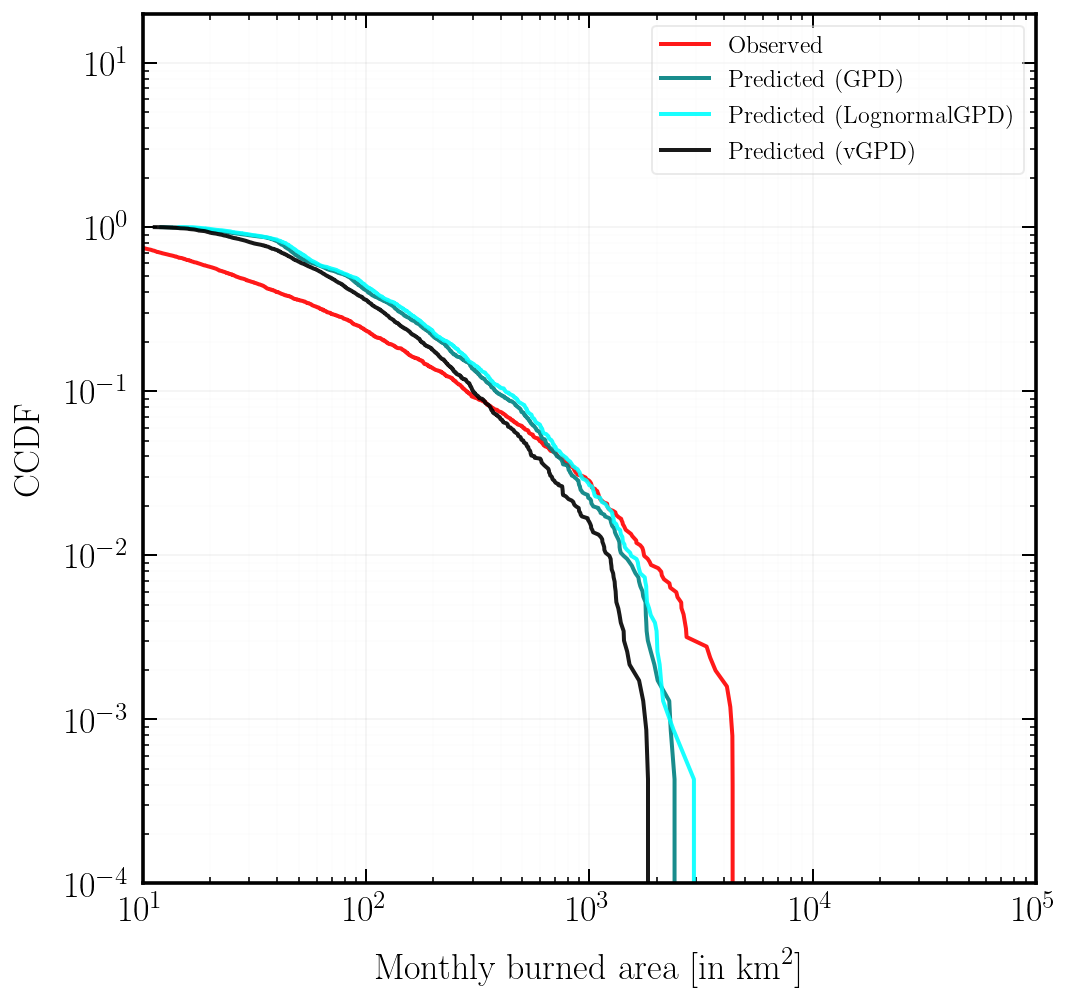

In [132]:
fig, ax= plt.subplots(figsize=(8, 8))

plt.plot(np.sort(obssizes_arr[obssizes_arr > 4]), 1 - np.sort(cdf_emp_obs), color= 'red', lw= 2, label= 'Observed')
plt.plot(np.sort(predsizes_gpd_arr[predsizes_gpd_arr > 4]), 1- np.sort(cdf_emp_gpd_pred), color= 'teal', lw= 2, label= 'Predicted (GPD)') 
plt.plot(np.sort(predsizes_lognorm_gpd_arr[predsizes_lognorm_gpd_arr > 4]), 1- np.sort(cdf_emp_lognorm_gpd_pred), color= 'cyan', lw= 2, label= 'Predicted (LognormalGPD)') 
plt.plot(np.sort(predsizes_data_arr[predsizes_data_arr > 4]), 1- np.sort(cdf_emp_data_pred), color= 'black', lw= 2, label= 'Predicted (vGPD)')
#plt.plot(np.sort(tot_arr), 1 - np.sort(cdf_emp_gpd_pred), color= 'purple', lw= 2, label= 'Predicted (Log mean)')

ax.set_xlabel(r'Monthly burned area [in ${\rm km}^2$]', fontsize= 18);
ax.set_ylabel(r'CCDF', fontsize= 18);

ax.set_ylim(10**-4, 20);
ax.set_xlim(10, 10**5);
plt.xscale('log')
plt.yscale('log')
plt.minorticks_on();
plt.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
plt.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
plt.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');

plt.legend(loc='upper right', frameon=True, fontsize=12);
#plt.savefig('../plots/grid_fire_size_ccdf_%s.pdf'%size_id, bbox_inches='tight');

### 4.5 CDF: fire sizes

In [12]:
size_id= '04_17_22'
mdn_gpd_mod= tf.keras.models.load_model('../sav_files/fire_size_mods/mdn_gpd_size_model_%s'%size_id, custom_objects= {'gpd_loss': gpd_loss, 'gpd_accuracy': gpd_accuracy})
mdn_gpd_ext_mod= tf.keras.models.load_model('../sav_files/fire_size_mods/mdn_gpd_ext_size_model_%s'%size_id, custom_objects= {'gpd_loss': gpd_loss, 'gpd_accuracy': gpd_accuracy})
#mdn_lognorm_gpd_mod= tf.keras.models.load_model('../sav_files/mdn_lognorm_gpd_size_model_%s'%size_id, custom_objects= {'lognorm_gpd_loss': lognorm_gpd_loss, 'lognorm_gpd_accuracy': lognorm_gpd_accuracy})

In [13]:
n_features= 36
start_month= 252 #for test data
tot_test_months= 180
end_month= start_month + tot_test_months

In [16]:
X_sizes_train, X_sizes_val, y_sizes_train, y_sizes_val, fire_size_train, fire_size_test, X_sizes_test, y_sizes_test, size_scaler= fire_size_data(res= '12km', \
                                                dropcols= ['CAPE', 'Solar', 'Ant_Tmax', 'RH', 'Ant_RH', 'FFWI_max7', 'Avgprec_4mo', 'Avgprec_2mo', \
                                                'AvgVPD_4mo', 'AvgVPD_2mo', 'Tmax_max7', 'VPD_max7', 'Tmin_max7'], start_month= start_month, tot_test_months= tot_test_months, threshold= 4) #size_scaler 'AvgVPD_2mo'

X_sizes_train_df= pd.concat([X_sizes_train, X_sizes_val], sort= False).reset_index().drop(columns=['index'])
X_sizes_tot= pd.concat([X_sizes_train_df, X_sizes_test], sort= False).reset_index().drop(columns=['index'])
fire_size_tot= pd.concat([fire_size_train, fire_size_test], sort= False).reset_index().drop(columns=['index'])

100%|██████████| 7705/7705 [00:27<00:00, 279.30it/s]


#### Western US

In [17]:
regmodels_train, tot_fires_train= theoretical_cdf_func(fire_size_train, X_sizes_train_df, mdn_mod= mdn_gpd_mod, start_month= 0, final_month= 252)
regmodels_test, tot_fires_test= theoretical_cdf_func(fire_size_test, X_sizes_test, mdn_mod= mdn_gpd_mod, start_month= 252, final_month= 432)
regmodels_ext_test, _= theoretical_cdf_func(fire_size_test, X_sizes_test, mdn_mod= mdn_gpd_ext_mod, start_month= 252, final_month= 432)
regmodels_tot, tot_fires= theoretical_cdf_func(fire_size_tot, X_sizes_tot, mdn_mod= mdn_gpd_mod, start_month= 0, final_month= 432)
regmodels_ext_tot, _= theoretical_cdf_func(fire_size_tot, X_sizes_tot, mdn_mod= mdn_gpd_ext_mod, start_month= 0, final_month= 432)

100%|██████████| 18/18 [01:40<00:00,  5.60s/it]


In [18]:
sizearr_train= (fire_size_train.loc[1:tot_fires_train, 'fire_size']/1e6).to_numpy() #np.logspace(0, 5, tot_fires) #mon_burned_area(fire_file, 1).values
sizearr_test= (fire_size_test.loc[1:tot_fires_test, 'fire_size']/1e6).to_numpy()
sizearr_tot= (fire_size_tot.loc[1:tot_fires, 'fire_size']/1e6).to_numpy() 

empcdf_train= tfd.Empirical(sizearr_train)
cdf_emp_train= empcdf_train.cdf(sizearr_train)
empcdf_test= tfd.Empirical(sizearr_test)
cdf_emp_test= empcdf_test.cdf(sizearr_test)
empcdf_tot= tfd.Empirical(sizearr_tot)
cdf_emp_tot= empcdf_tot.cdf(sizearr_tot)

cdf_mod_train= tfd.BatchConcat(regmodels_train, axis= 0).cdf(sizearr_train)
cdf_mod_test= tfd.BatchConcat(regmodels_test, axis= 0).cdf(np.logspace(0, 5, tot_fires_test))
cdf_mod_ext_test= tfd.BatchConcat(regmodels_ext_test, axis= 0).cdf(np.logspace(0, 5, tot_fires_test))
cdf_mod_tot= tfd.BatchConcat(regmodels_tot, axis= 0).cdf(sizearr_tot)
cdf_mod_ext_tot= tfd.BatchConcat(regmodels_ext_tot, axis= 0).cdf(np.logspace(0, 5, tot_fires))
cdf_mod_comb_tot= tfd.BatchConcat(list(np.append(regmodels_train, regmodels_ext_test)), axis= 0).cdf(sizearr_tot[1:])

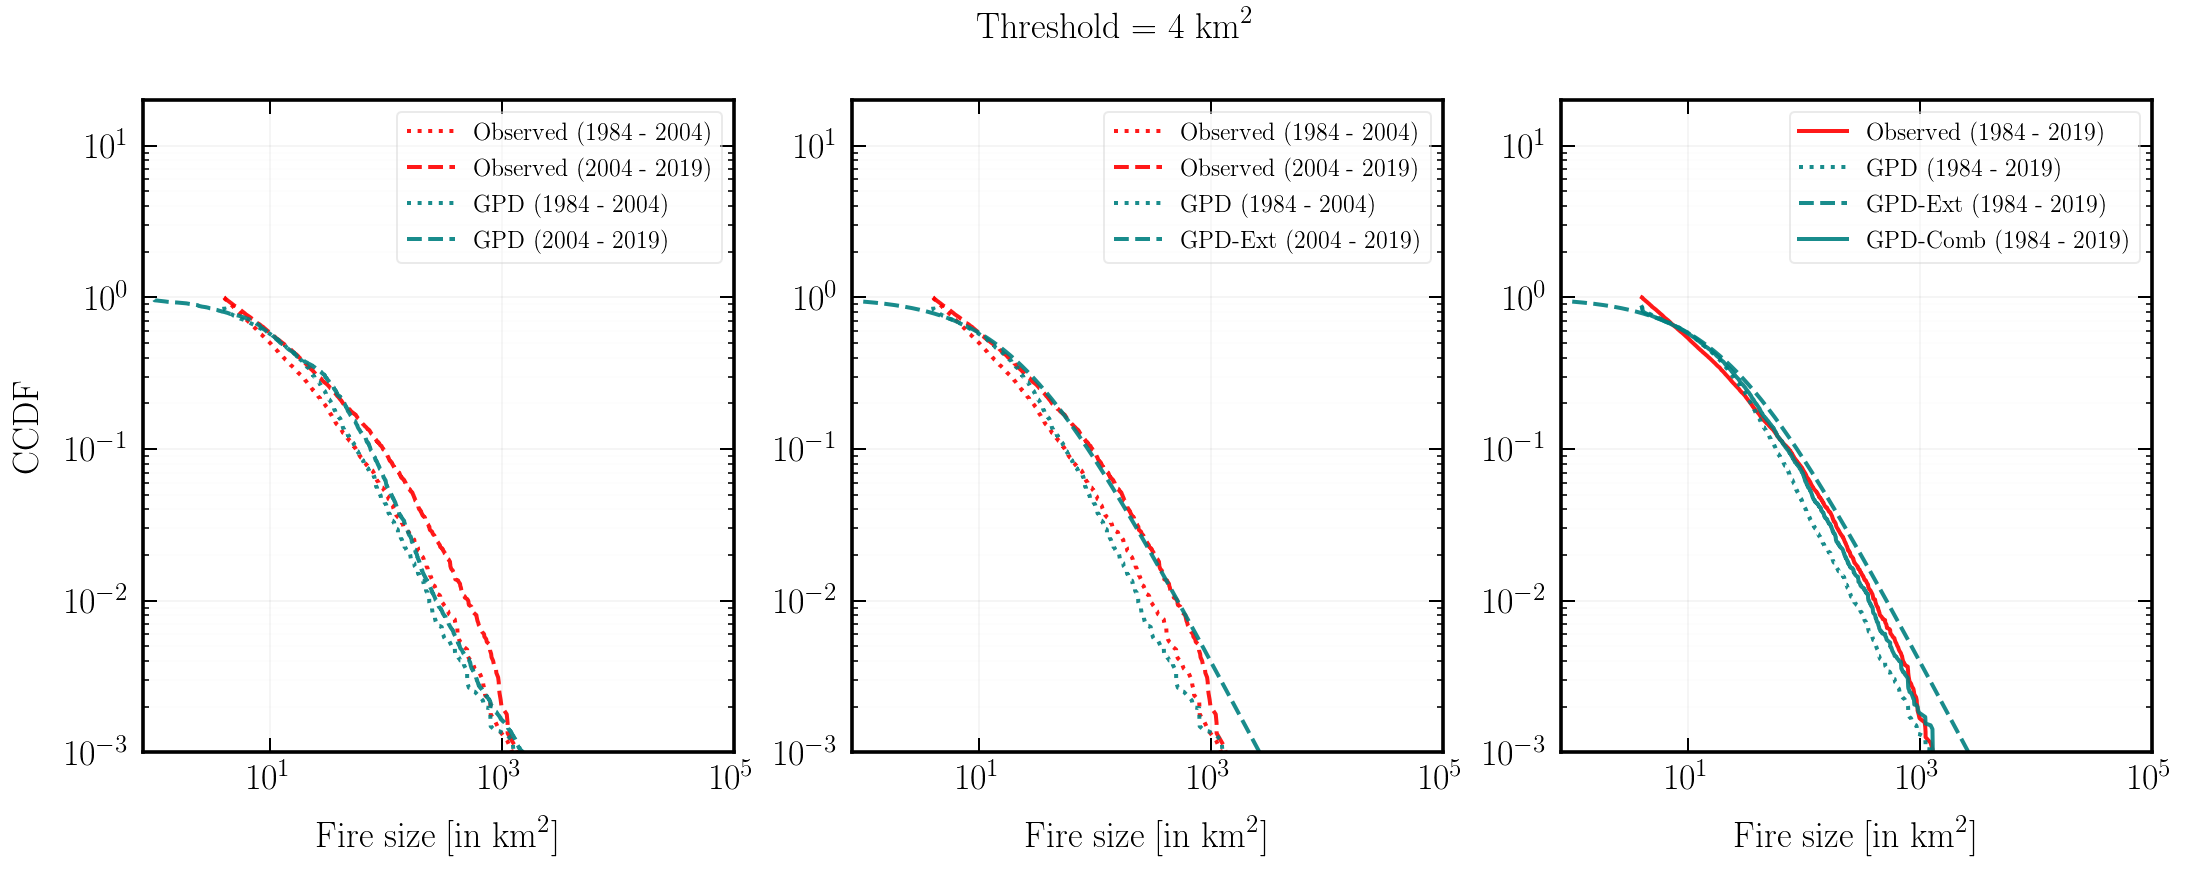

In [19]:
fig, ax= plt.subplots(1, 3, figsize=(18, 6))

ax[0].plot(np.sort(sizearr_train), 1 - np.sort(cdf_emp_train), color= 'red', lw= 2, linestyle= 'dotted', label= 'Observed (1984 - 2004)')
ax[0].plot(np.sort(sizearr_test), 1 - np.sort(cdf_emp_test), color= 'red', lw= 2, linestyle= 'dashed', label= 'Observed (2004 - 2019)')
ax[0].plot(np.sort(sizearr_train), 1 - np.sort(cdf_mod_train), color= 'teal', lw= 2, linestyle= 'dotted', label= 'GPD (1984 - 2004)')
ax[0].plot(np.logspace(0, 5, tot_fires_test), 1 - np.sort(cdf_mod_test), color= 'teal', lw= 2, linestyle= 'dashed', label= 'GPD (2004 - 2019)')

ax[0].set_xlabel(r'Fire size [in ${\rm km}^2$]', fontsize= 18);
ax[0].set_ylabel(r'CCDF', fontsize= 18);
ax[0].set_ylim(10**-3, 20);
ax[0].set_xlim(0.8, 10**5);
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].minorticks_on();
ax[0].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
ax[0].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[0].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
ax[0].legend(loc='upper right', frameon=True, fontsize=12);

ax[1].plot(np.sort(sizearr_train), 1 - np.sort(cdf_emp_train), color= 'red', lw= 2, linestyle= 'dotted', label= 'Observed (1984 - 2004)')
ax[1].plot(np.sort(sizearr_test), 1 - np.sort(cdf_emp_test), color= 'red', lw= 2, linestyle= 'dashed', label= 'Observed (2004 - 2019)')
ax[1].plot(np.sort(sizearr_train), 1 - np.sort(cdf_mod_train), color= 'teal', lw= 2, linestyle= 'dotted', label= 'GPD (1984 - 2004)')
ax[1].plot(np.logspace(0, 5, tot_fires_test), 1 - np.sort(cdf_mod_ext_test), color= 'teal', lw= 2, linestyle= 'dashed', label= 'GPD-Ext (2004 - 2019)')

ax[1].set_xlabel(r'Fire size [in ${\rm km}^2$]', fontsize= 18);
ax[1].set_ylim(10**-3, 20);
ax[1].set_xlim(0.8, 10**5);
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].minorticks_on();
ax[1].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
ax[1].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[1].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
ax[1].legend(loc='upper right', frameon=True, fontsize=12);

ax[2].plot(np.sort(sizearr_tot), 1 - np.sort(cdf_emp_tot), color= 'red', lw= 2, label= 'Observed (1984 - 2019)')
ax[2].plot(np.sort(sizearr_tot), 1 - np.sort(cdf_mod_tot), color= 'teal', lw= 2, linestyle= 'dotted', label= 'GPD (1984 - 2019)')
ax[2].plot(np.logspace(0, 5, tot_fires), 1 - np.sort(cdf_mod_ext_tot), color= 'teal', lw= 2, linestyle= 'dashed', label= 'GPD-Ext (1984 - 2019)')
ax[2].plot(np.sort(sizearr_tot[1:]), 1 - np.sort(cdf_mod_comb_tot), color= 'teal', lw= 2, label= 'GPD-Comb (1984 - 2019)')

ax[2].set_xlabel(r'Fire size [in ${\rm km}^2$]', fontsize= 18);
ax[2].set_ylim(10**-3, 20);
ax[2].set_xlim(0.8, 10**5);
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].minorticks_on();
ax[2].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
ax[2].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[2].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
ax[2].legend(loc='upper right', frameon=True, fontsize=12);

plt.suptitle(r'Threshold = 4 ${\rm km}^2$', fontsize= 18);
#plt.savefig('../plots/fire_size_ccdf_b2009_%s.pdf'%size_id, bbox_inches='tight');

#### Regional CDFs

In [38]:
rindx= 14
regmodels_ims_train, tot_fires_ims_train= theoretical_cdf_func(fire_size_train, X_sizes_train_df, mdn_mod= mdn_gpd_mod, start_month= 0, final_month= break_month, regmode= True, regindx= rindx)
regmodels_ims_test, tot_fires_ims_test= theoretical_cdf_func(fire_size_test, X_sizes_test, mdn_mod= mdn_gpd_mod, start_month= break_month, final_month= 432, regmode= True, regindx= rindx)
regmodels_ims_ext_test, _= theoretical_cdf_func(fire_size_test, X_sizes_test, mdn_mod= mdn_gpd_ext_mod, start_month= break_month, final_month= 432, regmode= True, regindx= rindx)
regmodels_ims_tot, tot_ims_fires= theoretical_cdf_func(fire_size_tot, X_sizes_tot, mdn_mod= mdn_gpd_mod, start_month= 0, final_month= 432, regmode= True, regindx= rindx)
regmodels_ims_ext_tot, _= theoretical_cdf_func(fire_size_tot, X_sizes_tot, mdn_mod= mdn_gpd_ext_mod, start_month= 0, final_month= 432, regmode= True, regindx= rindx)

In [39]:
sizearr_ims_train= (fire_size_train.groupby('reg_indx').get_group(rindx)['fire_size']/1e6).to_numpy()
sizearr_ims_test= (fire_size_test.groupby('reg_indx').get_group(rindx)['fire_size']/1e6).to_numpy()
sizearr_ims_tot= (fire_size_tot.groupby('reg_indx').get_group(rindx)['fire_size']/1e6).to_numpy()

empcdf_ims_train= tfd.Empirical(sizearr_ims_train)
cdf_emp_ims_train= empcdf_ims_train.cdf(sizearr_ims_train)
empcdf_ims_test= tfd.Empirical(sizearr_ims_test)
cdf_emp_ims_test= empcdf_ims_test.cdf(sizearr_ims_test)
empcdf_ims_tot= tfd.Empirical(sizearr_ims_tot)
cdf_emp_ims_tot= empcdf_ims_tot.cdf(sizearr_ims_tot)

cdf_mod_ims_train= tfd.BatchConcat(regmodels_ims_train, axis= 0).cdf(sizearr_ims_train)
cdf_mod_ims_test= tfd.BatchConcat(regmodels_ims_test, axis= 0).cdf(np.logspace(0, 5, tot_fires_ims_test))
cdf_mod_ims_ext_test= tfd.BatchConcat(regmodels_ims_ext_test, axis= 0).cdf(np.logspace(0, 5, tot_fires_ims_test))
cdf_mod_ims_tot= tfd.BatchConcat(regmodels_ims_tot, axis= 0).cdf(sizearr_ims_tot)
cdf_mod_ims_ext_tot= tfd.BatchConcat(regmodels_ims_ext_tot, axis= 0).cdf(np.logspace(0, 5, tot_ims_fires))
cdf_mod_ims_comb_tot= tfd.BatchConcat(list(np.append(regmodels_ims_train, regmodels_ims_ext_test)), axis= 0).cdf(sizearr_ims_tot)

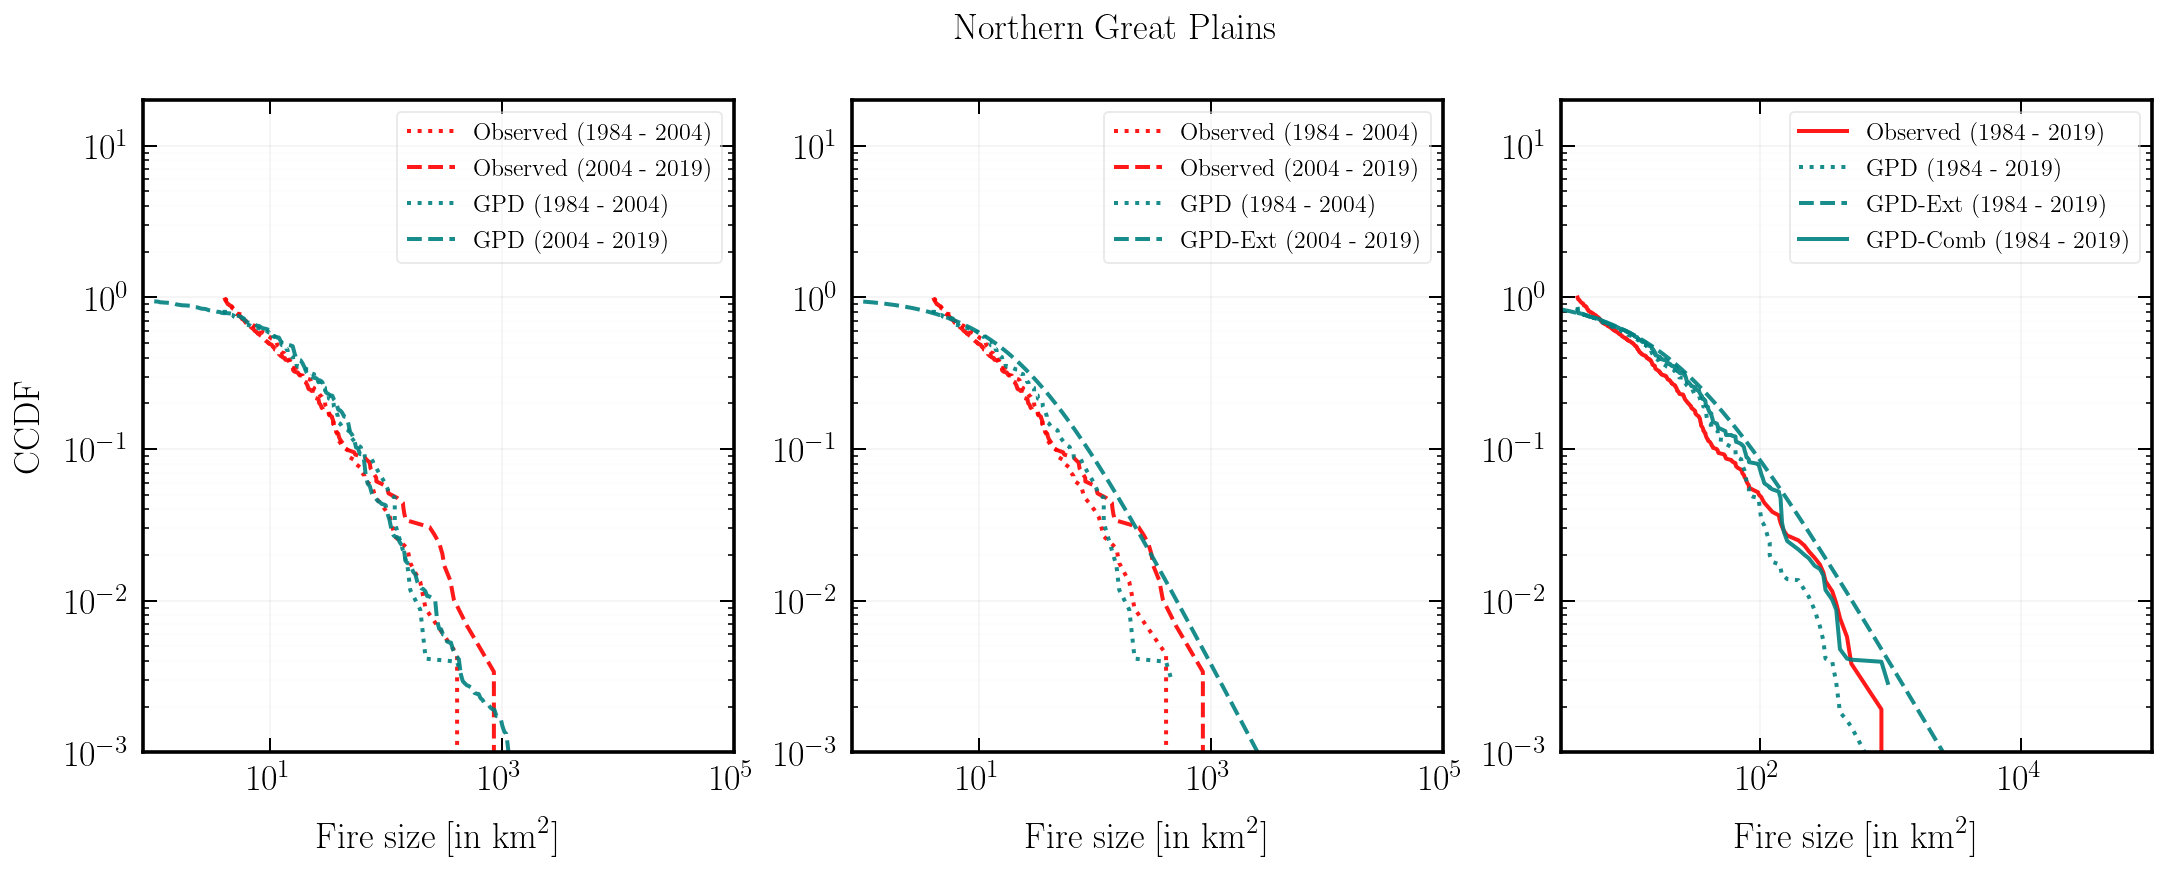

In [40]:
fig, ax= plt.subplots(1, 3, figsize=(18, 6))

ax[0].plot(np.sort(sizearr_ims_train), 1 - np.sort(cdf_emp_ims_train), color= 'red', lw= 2, linestyle= 'dotted', label= 'Observed (1984 - 2004)')
ax[0].plot(np.sort(sizearr_ims_test), 1 - np.sort(cdf_emp_ims_test), color= 'red', lw= 2, linestyle= 'dashed', label= 'Observed (2004 - 2019)')
ax[0].plot(np.sort(sizearr_ims_train), 1 - np.sort(cdf_mod_ims_train), color= 'teal', lw= 2, linestyle= 'dotted', label= 'GPD (1984 - 2004)')
ax[0].plot(np.logspace(0, 5, tot_fires_ims_test), 1 - np.sort(cdf_mod_ims_test), color= 'teal', lw= 2, linestyle= 'dashed', label= 'GPD (2004 - 2019)')

ax[0].set_xlabel(r'Fire size [in ${\rm km}^2$]', fontsize= 18);
ax[0].set_ylabel(r'CCDF', fontsize= 18);
ax[0].set_ylim(10**-3, 20);
ax[0].set_xlim(0.8, 10**5);
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].minorticks_on();
ax[0].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
ax[0].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[0].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
ax[0].legend(loc='upper right', frameon=True, fontsize=12);

ax[1].plot(np.sort(sizearr_ims_train), 1 - np.sort(cdf_emp_ims_train), color= 'red', lw= 2, linestyle= 'dotted', label= 'Observed (1984 - 2004)')
ax[1].plot(np.sort(sizearr_ims_test), 1 - np.sort(cdf_emp_ims_test), color= 'red', lw= 2, linestyle= 'dashed', label= 'Observed (2004 - 2019)')
ax[1].plot(np.sort(sizearr_ims_train), 1 - np.sort(cdf_mod_ims_train), color= 'teal', lw= 2, linestyle= 'dotted', label= 'GPD (1984 - 2004)')
ax[1].plot(np.logspace(0, 5, tot_fires_ims_test), 1 - np.sort(cdf_mod_ims_ext_test), color= 'teal', lw= 2, linestyle= 'dashed', label= 'GPD-Ext (2004 - 2019)')

ax[1].set_xlabel(r'Fire size [in ${\rm km}^2$]', fontsize= 18);
ax[1].set_ylim(10**-3, 20);
ax[1].set_xlim(0.8, 10**5);
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].minorticks_on();
ax[1].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
ax[1].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[1].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
ax[1].legend(loc='upper right', frameon=True, fontsize=12);

ax[2].plot(np.sort(sizearr_ims_tot), 1 - np.sort(cdf_emp_ims_tot), color= 'red', lw= 2, label= 'Observed (1984 - 2019)')
ax[2].plot(np.sort(sizearr_ims_tot), 1 - np.sort(cdf_mod_ims_tot), color= 'teal', lw= 2, linestyle= 'dotted', label= 'GPD (1984 - 2019)')
ax[2].plot(np.logspace(0, 5, tot_ims_fires), 1 - np.sort(cdf_mod_ims_ext_tot), color= 'teal', lw= 2, linestyle= 'dashed', label= 'GPD-Ext (1984 - 2019)')
ax[2].plot(np.sort(sizearr_ims_tot), 1 - np.sort(cdf_mod_ims_comb_tot), color= 'teal', lw= 2, label= 'GPD-Comb (1984 - 2019)')

ax[2].set_xlabel(r'Fire size [in ${\rm km}^2$]', fontsize= 18);
ax[2].set_ylim(10**-3, 20);
ax[2].set_xlim(3, 10**5);
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].minorticks_on();
ax[2].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
ax[2].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[2].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
ax[2].legend(loc='upper right', frameon=True, fontsize=12);

plt.suptitle(r'${\rm Northern \ Great \ Plains}$', fontsize= 18);
#plt.savefig('../plots/fire_size_ccdf_b2009_%s.pdf'%size_id, bbox_inches='tight');

## Sanity check

In [40]:
tmparr= np.random.choice(np.nonzero(freq_arr[6])[0], (np.sum(freq_arr[6])*(np.std(reg_freq_groups.get_group(1)['obs_freq'])/np.std(pred_freq))).astype(int))

In [41]:
X_test_df.groupby('reg_indx').get_group(1).groupby('month').get_group(m).drop(columns= ['reg_indx', 'month']).index.to_numpy()[tmparr]

array([3746133, 3741808, 3750194, 3741511, 3748828, 3749649, 3742959])

In [13]:
dnn_freq_df= pd.read_hdf('../sav_files/dnn_mon_fire_freq_03_01_22_it_12_8192_0.3.h5')
dnn_freq_groups= dnn_freq_df.groupby('reg_indx')

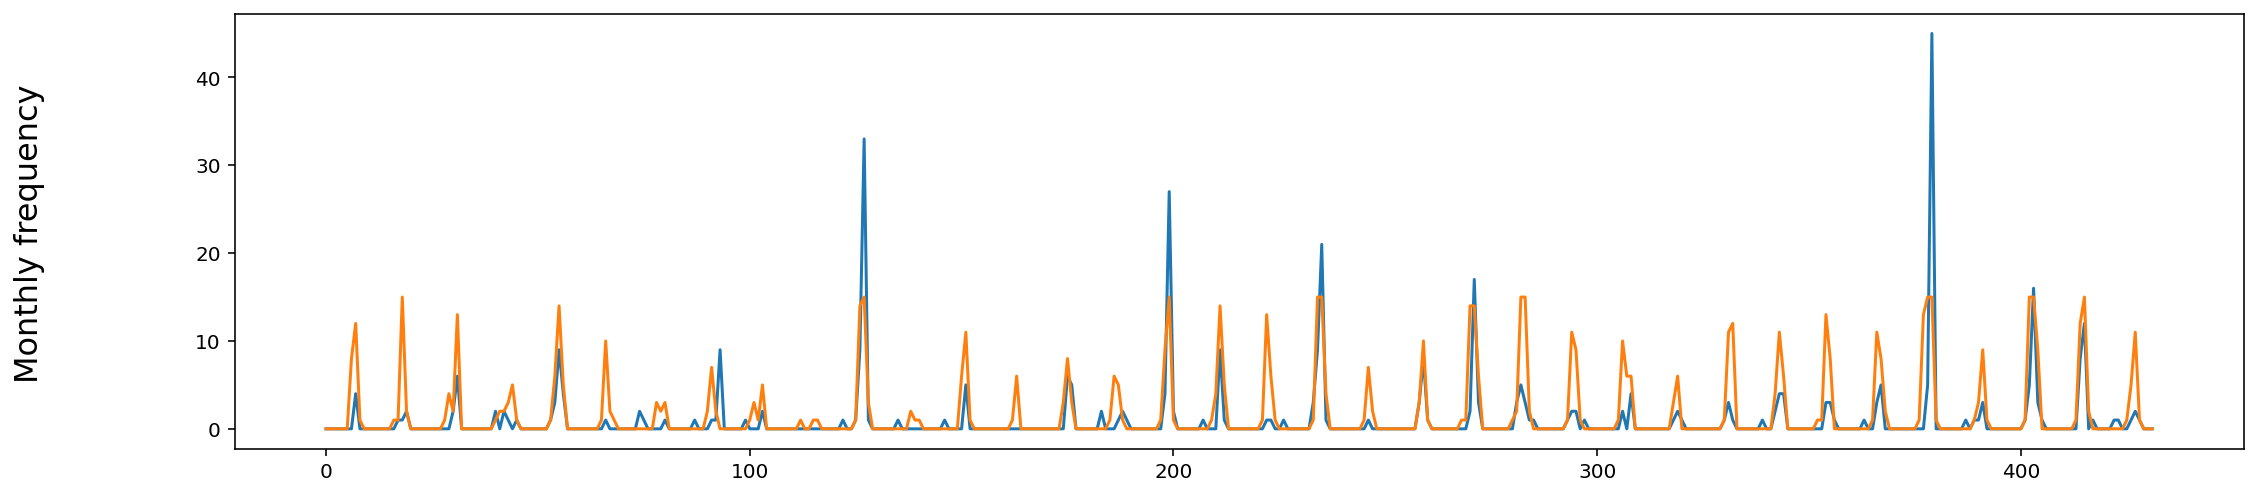

In [24]:
fig, ax= plt.subplots(1, 1, figsize=(18, 4))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly frequency', va='center', rotation='vertical', fontsize= 16);
regindx= 7

plt.plot(month_arr, dnn_freq_groups.get_group(regindx)['obs_freq'])
plt.plot(month_arr, dnn_freq_groups.get_group(regindx)['pred_mean_freq']);
#plt.fill_between(month_arr, mdn_freq_groups.get_group(regindx)['pred_high_2sig'], mdn_freq_groups.get_group(regindx)['pred_low_2sig'], color= 'orange', alpha= 0.3)

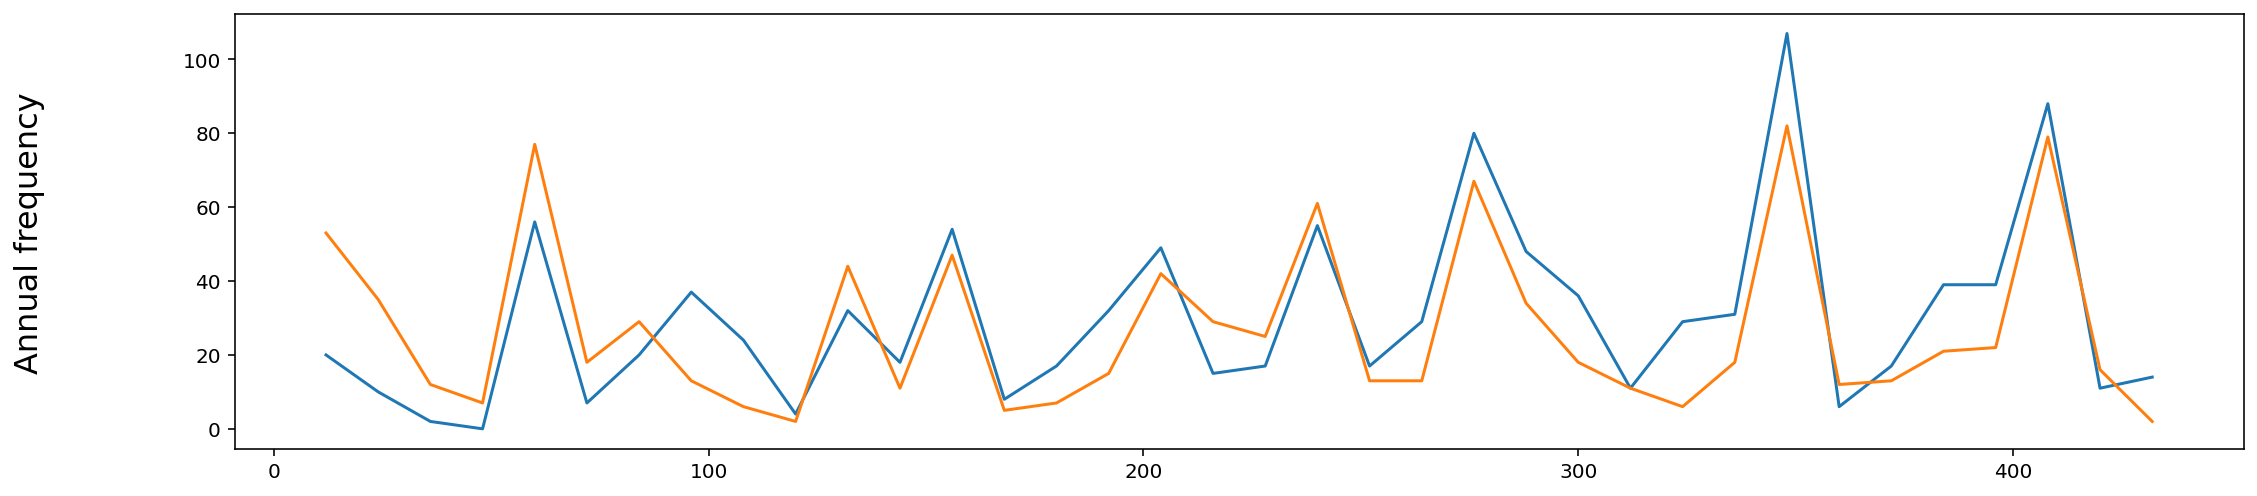

In [23]:
fig, ax= plt.subplots(1, 1, figsize=(18, 4))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Annual frequency', va='center', rotation='vertical', fontsize= 16);
regindx= 14

#pred_std= np.asarray([np.sqrt(np.sum((((mdn_freq_groups.get_group(regindx)['pred_high_2sig'] - \
#                    mdn_freq_groups.get_group(regindx)['pred_low_2sig'])/4)**2)[yr_arr[t]:yr_arr[t+1]])) for t in range(len(yr_arr) - 1)])  
pred_freq= np.array([np.sum(dnn_freq_groups.get_group(regindx)['pred_mean_freq'][yr_arr[t]:yr_arr[t+1]]) for t in range(len(yr_arr) - 1)])

plt.plot(yr_arr[1:], np.array([np.sum(dnn_freq_groups.get_group(regindx)['obs_freq'][yr_arr[t]:yr_arr[t+1]]) for t in range(len(yr_arr) - 1)]));
plt.plot(yr_arr[1:], pred_freq);
#plt.fill_between(yr_arr[1:], pred_freq + 2*pred_std, pred_freq - 2*pred_std, color= 'orange', alpha= 0.3)